In [1]:
# disruption in a period, then return to normal state（done)

# for bigger difference visually, use ratio(assume normal state 1)
# sensitive analysis(partly done) now in a snipshot, maybe another plot style?
# larger agent size (area size)










In [1]:
import random
import numpy as np
import math
import mesa
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import BaseScheduler
import pandas as pd
from SCN.agent import Order, Customer, Manufacturer, Supplier, manhattan_distance
from SCN.model import update_transport_cost_for_order, random_position_unique, SupplyChainGridModel,calculate_unit_cost

In [33]:
df = pd.read_csv("SCN/supply_chain_data.csv")
df.rename(columns={"Stock levels": "inventory"}, inplace=True)
df["inventory"] = df["inventory"].apply(lambda x: math.ceil(x) if pd.notnull(x) else x)
df["Order quantities"] = df["Order quantities"].apply(lambda x: math.ceil(x) if pd.notnull(x) else x)
df = df[["inventory", "Order quantities"]]
inventory_count = df["inventory"].count()
order_qty_count = df["Order quantities"].count()
print("inventory 列数据个数（非空）:", inventory_count)
print("Order quantities 列数据个数（非空）:", order_qty_count)
print(df.head())
demands_list = df["Order quantities"].dropna().tolist()
inventory_list = df["inventory"].dropna().astype(int).tolist()
inventory_mean = df["inventory"].mean()
order_qty_mean = df["Order quantities"].mean()

print(f"Inventory 列的均值: {inventory_mean}")
print(f"Order quantities 列的均值: {order_qty_mean}")

inventory 列数据个数（非空）: 100
Order quantities 列数据个数（非空）: 100
   inventory  Order quantities
0         58                96
1         53                37
2          1                88
3         23                59
4          5                56
Inventory 列的均值: 47.77
Order quantities 列的均值: 49.22


In [40]:
df = pd.read_csv("SCN/DataCoSupplyChainDataset.csv", encoding="latin1")
df = df[["Customer Id", "Latitude", "Longitude"]]
df_unique = df.drop_duplicates()
df_sample = df_unique.sample(n=40, random_state=43)

# 3. 先利用 rank 得到初始坐标，保证原始数据不同对应不同数值
df_sample["x"] = df_sample["Latitude"].rank(method="dense", ascending=True).astype(int)
df_sample["y"] = df_sample["Longitude"].rank(method="dense", ascending=True).astype(int)

# 4. 将坐标缩放：简单的除以2，再取整，使数值变小
df_sample["x"] = np.ceil(df_sample["x"] / 4).astype(int)
df_sample["y"] = np.ceil(df_sample["y"] / 4).astype(int)

# 5. 去重：若缩放后出现多个点落在同一格，则只保留一条记录
df_final = df_sample.drop_duplicates(subset=["x", "y"])

# 6. 查看结果
print(df_final[["Customer Id", "Latitude", "Longitude", "x", "y"]])
print("Number of rows in df_final:", df_final.shape[0])
positions = df_final[["x", "y"]].values.tolist()

        Customer Id   Latitude   Longitude   x   y
55375          1672  34.077606 -117.240181   6   2
7248           4567  18.210739  -66.370605   1   8
16153         14473  38.611774 -121.282867   8   1
97197         17450  26.145800  -97.958252   4   3
71502         15468  34.748348  -77.428482   7   6
120672        12651  40.763580  -73.830040  10   7
26189          8613  18.285648  -66.370613   3   7
34169         16312  40.508579  -88.982643   9   4
23487         17513  40.575642  -73.995209   9   7
88976         19990  33.089520 -117.255203   5   2
3550           3223  18.228659  -66.370560   2   9
26483         12591  18.212404  -66.037056   1  10
18823         11606  35.731037  -78.855751   7   5
8436           9658  29.696537  -95.645920   4   4
17043         14253  38.796600  -90.346405   8   4
25600          1953  39.000355  -77.227814   8   6
70368         13329  41.274368 -111.962868  10   3
7940           8915  18.216906  -66.370514   1   9
175609        17268  18.223112 

In [41]:
import networkx as nx

def get_weighted_edge_count(model):
    """
    构建一个 MultiGraph，将模型中所有代理作为节点，
    对于每个 delivered_orders 中已完成且已发货的订单，
    在发货方和收货方之间添加一条边，边的权重为订单数量。
    返回图中所有边的权重和，即为 weighted edge count。
    """
    G = nx.MultiGraph()
    for agent in model.schedule.agents:
        G.add_node(agent.unique_id)
    for order in model.delivered_orders:
        if order.completed and order.shipped and order.order_type == "product":
            # 添加边时指定 weight 属性为订单数量
            G.add_edge(order.sender_id, order.receiver_id, weight=order.quantity)
    total_weight = sum(data.get('weight', 1) for u, v, data in G.edges(data=True))
    return total_weight


In [43]:
def run_simulation_with_param_changes(
        heterogeneous=False,
        cust_demand_multiplier=1.0,
        m_production_capacity=80,
        m_inventory_capacity_product=400,
        m_inventory_capacity_material=800,
        s_material_capacity=300,
        m_cap_mode="homogeneous",
        logistics_speed=2.0,
        rm_procurement_mode="gap_based",
        rm_reorder_point=30,
        rm_reorder_target=500,
        rm_purchase_multiplier=1.8,
        rm_produce_multiplier=1.7,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=1000,
        num_reps=2,
        change_schedule=None,
        return_model=False):
    """
    运行 num_reps 次仿真，并在运行过程中按 change_schedule 更新参数。
    返回：
        mean_prod_ratio:      平均时效比（可删）
        mean_unit_cost:       平均单位成本（可删）
        mean_edge_series:     每步平均加权边数
        std_edge_series:      每步加权边数标准差
        phase_metrics:        各阶段指标 (ratio, unit_cost, 完成量)
        mean_ratio_series:    每步平均时效比
        std_ratio_series:     每步时效比标准差
        mean_unit_cost_series: 每步平均单位成本
        std_unit_cost_series:  每步单位成本标准差
    """
    ratio_prod_list = []
    unit_cost_list = []
    weighted_edge_count_list = []

    ratio_series_list = []
    unit_cost_series_list = []

    for rep in range(num_reps):
        try:
            from SCN.agent import used_positions
            used_positions.clear()
        except:
            pass

        model = SupplyChainGridModel(
            positions=positions,
            demands_list=demands_list,
            inventory_list=inventory_list,
            num_customers=20,
            num_manufacturers=6,
            num_suppliers=4,
            cust_demand_probability=0.4,
            cust_demand_multiplier=cust_demand_multiplier,
            m_production_capacity=m_production_capacity,
            m_inventory_capacity_product=m_inventory_capacity_product,
            m_inventory_capacity_material=m_inventory_capacity_material,
            s_material_capacity=s_material_capacity,
            m_cap_mode=m_cap_mode,
            logistics_speed=logistics_speed,
            rm_procurement_mode=rm_procurement_mode,
            rm_reorder_point=rm_reorder_point,
            rm_reorder_target=rm_reorder_target,
            rm_purchase_multiplier=rm_purchase_multiplier,
            rm_produce_multiplier=rm_produce_multiplier,
            product_order_mode=product_order_mode,
            material_order_mode=material_order_mode
        )

        rep_edge_series = []
        rep_ratio_series = []
        rep_unit_cost_series = []

        if change_schedule:
            points = sorted(p for p in change_schedule if 0 < p <= total_steps)
        else:
            points = []
        points.append(total_steps)
        snapshots = [(0, 0, 0, 0)]
        next_change_index = 0

        for current_step in range(1, total_steps+1):
            model.step()

            # 记录 weighted edge count
            rep_edge_series.append(get_weighted_edge_count(model))

            # 记录当前时效比 & 单位成本
            prod_orders = [
                o for o in model.delivered_orders
                if o.order_type == "product" and o.actual_delivery_time is not None
            ]
            sum_act = sum(o.actual_delivery_time for o in prod_orders)
            sum_theo = sum(o.theoretical_delivery_time for o in prod_orders)
            current_ratio = sum_act / sum_theo if sum_theo > 0 else 0
            uc = calculate_unit_cost(model)
            current_uc = uc if uc is not None else 0.0

            rep_ratio_series.append(current_ratio)
            rep_unit_cost_series.append(current_uc)

            # 参数变更处理
            if change_schedule and current_step in change_schedule:
                changes = change_schedule[current_step]
                if "product_order_mode" in changes:
                    for c in model.customers:
                        c.order_mode = changes["product_order_mode"]
                if "cust_demand_multiplier" in changes:
                    for c in model.customers:
                        c.cust_demand_multiplier = changes["cust_demand_multiplier"]
                if "logistics_speed" in changes:
                    model.logistics_speed = changes["logistics_speed"]
                if "m_production_capacity" in changes:
                    for m in model.manufacturers:
                        m.production_capacity = changes["m_production_capacity"]
                if "rm_procurement_mode" in changes:
                    for m in model.manufacturers:
                        m.rm_procurement_mode = changes["rm_procurement_mode"]
                if "rm_purchase_multiplier" in changes:
                    for m in model.manufacturers:
                        m.rm_purchase_multiplier = changes["rm_purchase_multiplier"]
                if "material_order_mode" in changes:
                    for m in model.manufacturers:
                        m.material_order_mode = changes["material_order_mode"]
                if "inventory_capacity_material" in changes:
                    for m in model.manufacturers:
                        m.inventory_capacity_material = changes["inventory_capacity_material"]

            # 阶段结束快照
            if current_step == points[next_change_index]:
                prod_orders = [
                    o for o in model.delivered_orders
                    if o.order_type == "product" and o.actual_delivery_time is not None
                ]
                sum_act  = sum(o.actual_delivery_time   for o in prod_orders)
                sum_theo = sum(o.theoretical_delivery_time for o in prod_orders)
                total_cost = sum(
                    m.cumulative_storage_cost_product +
                    m.cumulative_storage_cost_material +
                    m.cumulative_transport_cost +
                    m.cumulative_penalty_cost
                    for m in model.manufacturers
                )
                total_comp = sum(m.completed_products for m in model.manufacturers)
                snapshots.append((sum_act, sum_theo, total_cost, total_comp))
                next_change_index += 1

        # 保存 rep 结果
        weighted_edge_count_list.append(rep_edge_series)
        ratio_series_list.append(rep_ratio_series)
        unit_cost_series_list.append(rep_unit_cost_series)

        # 整体平均指标
        sum_act = sum(o.actual_delivery_time for o in model.delivered_orders
                      if o.order_type == "product" and o.actual_delivery_time is not None)
        sum_theo = sum(o.theoretical_delivery_time for o in model.delivered_orders
                       if o.order_type == "product" and o.actual_delivery_time is not None)
        ratio_prod = sum_act / sum_theo if sum_theo > 0 else 0
        ratio_prod_list.append(ratio_prod)

        uc = calculate_unit_cost(model)
        unit_cost_list.append(uc if uc is not None else 0.0)

    # 计算跨 reps 的平均和 std
    edge_arr = np.array(weighted_edge_count_list)
    mean_edge = np.mean(edge_arr, axis=0)
    std_edge = np.std(edge_arr, axis=0)

    ratio_arr = np.array(ratio_series_list)
    mean_ratio = np.mean(ratio_arr, axis=0)
    std_ratio = np.std(ratio_arr, axis=0)

    uc_arr = np.array(unit_cost_series_list)
    mean_uc = np.mean(uc_arr, axis=0)
    std_uc = np.std(uc_arr, axis=0)

    # 阶段性指标
    phase_metrics = []
    for i in range(len(snapshots)-1):
        a0, t0, c0, p0 = snapshots[i]
        a1, t1, c1, p1 = snapshots[i+1]
        da, dt, dc, dp = a1-a0, t1-t0, c1-c0, p1-p0
        r = da/dt if dt > 0 else 0
        uc_phase = dc/dp if dp > 0 else 0
        phase_metrics.append((r, uc_phase, dp))

    results = (
        np.mean(ratio_prod_list),
        np.mean(unit_cost_list),
        mean_edge,
        std_edge,
        phase_metrics,
        mean_ratio,
        std_ratio,
        mean_uc,
        std_uc
    )
    return (model, results) if return_model else results

Running scenario: Strategy A
—— Per-Phase Metrics for Strategy A ——
 Step   200:   Ratio = 4.128,   UnitCost = 65.156,   Completed = 74460.0
 Step  2000:   Ratio = 4.923,   UnitCost = 82.042,   Completed = 704006.0
 Step  3000:   Ratio = 5.131,   UnitCost = 84.451,   Completed = 399668.0
Running scenario: Strategy B
—— Per-Phase Metrics for Strategy B ——
 Step   200:   Ratio = 4.077,   UnitCost = 74.309,   Completed = 71473.0
 Step   600:   Ratio = 5.005,   UnitCost = 93.816,   Completed = 157965.0
 Step  2000:   Ratio = 4.079,   UnitCost = 74.459,   Completed = 548065.0
 Step  3000:   Ratio = 4.076,   UnitCost = 74.245,   Completed = 393917.0
Running scenario: Strategy C
—— Per-Phase Metrics for Strategy C ——
 Step   200:   Ratio = 4.140,   UnitCost = 69.120,   Completed = 71899.0
 Step   600:   Ratio = 5.990,   UnitCost = 112.307,   Completed = 154395.0
 Step  2000:   Ratio = 10.895,   UnitCost = 214.034,   Completed = 542395.0
 Step  3000:   Ratio = 21.019,   UnitCost = 414.718,   C

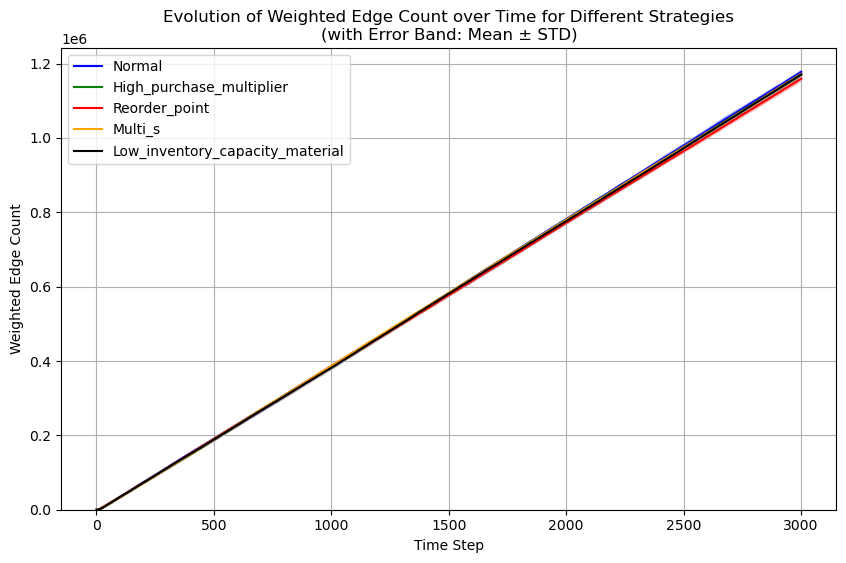

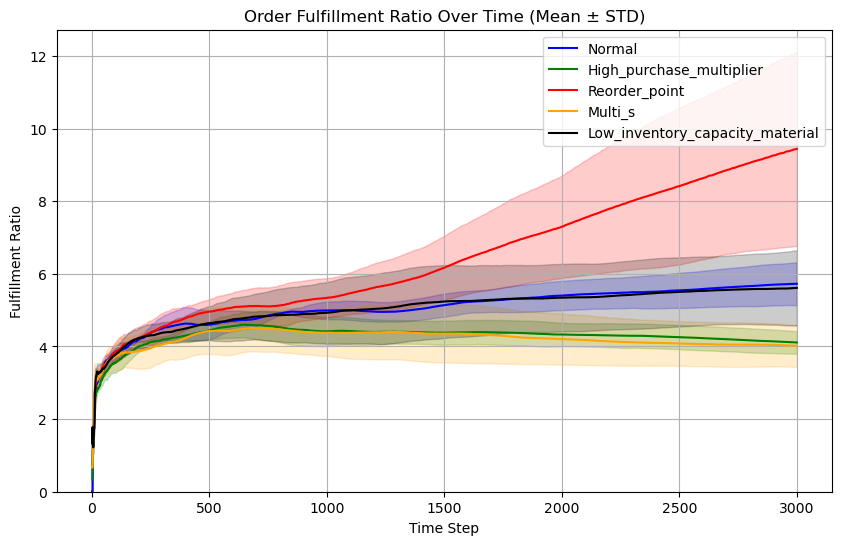

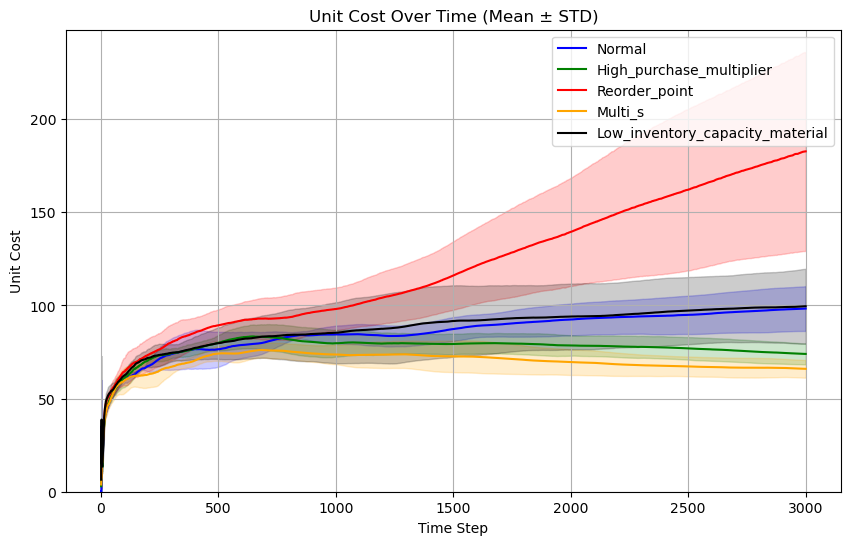

In [65]:
# material capacity change
change_schedule_A = {
    200: {"s_material_capacity": 50},
    2000: {"s_material_capacity": 400}
}
change_schedule_B = {
    200: {"s_material_capacity": 50},
    600: {"rm_purchase_multiplier": 2},
    2000: {"s_material_capacity": 400}
}
change_schedule_C = {
    200: {"s_material_capacity": 50},
    600: {"rm_procurement_mode": "reorder_point"},
    2000: {"s_material_capacity": 400}
}
change_schedule_D = {
    200: {"s_material_capacity": 50},
    600: {"material_order_mode":"multi_s"},
    2000: {"s_material_capacity": 400}
}
change_schedule_E = {
    200: {"s_material_capacity": 50},
    600: {"m_inventory_capacity_material":200},
    2000: {"s_material_capacity": 400}
}

total_steps = 3000

def run_scenario(scenario_name, change_schedule):
    print(f"Running scenario: {scenario_name}")
    results = run_simulation_with_param_changes(
        heterogeneous=True,
        cust_demand_multiplier=1.0,
        m_production_capacity=80,
        m_inventory_capacity_product=300,
        m_inventory_capacity_material=600,
        s_material_capacity=400,
        m_cap_mode="heterogeneous",  # 这里可以选择 "heterogeneous" 或其他模式
        logistics_speed=2.0,
        rm_procurement_mode="gap_based",
        rm_reorder_point=300,
        rm_reorder_target=600,
        rm_purchase_multiplier=1.1,
        rm_produce_multiplier=1.1,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=3000,
        num_reps=3,
        change_schedule=change_schedule,
        return_model=False
    )
    # 这里 results = (mean_prod_ratio, mean_unit_cost, mean_weighted_edge_count)
    (
        mean_prod_ratio,
        mean_unit_cost,
        mean_edge_series,
        std_edge_series,
        phase_metrics,
        mean_ratio_series,
        std_ratio_series,
        mean_uc_series,
        std_uc_series
    ) = results

     # 按变更点打印每一段的指标
    points = sorted([p for p in change_schedule.keys() if p <= total_steps] + [total_steps])
    print(f"—— Per-Phase Metrics for {scenario_name} ——")
    for idx, step in enumerate(points):
        r, uc_phase, completed_count = phase_metrics[idx]
        print(f" Step {step:>5}:   Ratio = {r:.3f},   UnitCost = {uc_phase:.3f},   Completed = {completed_count}")
    return {
        "mean_ratio": mean_prod_ratio,
        "mean_unit_cost": mean_unit_cost,
        "mean_edge_series": mean_edge_series,
        "std_edge_series": std_edge_series,
        "phase_metrics": phase_metrics,
        "mean_ratio_series": mean_ratio_series,
        "std_ratio_series": std_ratio_series,
        "mean_uc_series": mean_uc_series,
        "std_uc_series": std_uc_series
    }
# 分别运行 4 个不同场景
results_A = run_scenario("Strategy A", change_schedule_A)
results_B = run_scenario("Strategy B", change_schedule_B)
results_C = run_scenario("Strategy C", change_schedule_C)
results_D = run_scenario("Strategy D", change_schedule_D)
results_E = run_scenario("Strategy E", change_schedule_E)
time_steps = np.arange(1, total_steps + 1)

# 从各个策略的 simulation 返回结果中提取 weighted edge count 的均值和标准差
# 假设 run_scenario 返回的结果格式为：
# (mean_cap, mean_prod_ratio, mean_statusN, mean_unit_cost, mean_edge_series, std_edge_series)
mean_edge_series_A = results_A["mean_edge_series"]
std_edge_series_A = results_A["std_edge_series"]

mean_edge_series_B = results_B["mean_edge_series"]
std_edge_series_B = results_B["std_edge_series"]

mean_edge_series_C = results_C["mean_edge_series"]
std_edge_series_C = results_C["std_edge_series"]

mean_edge_series_D = results_D["mean_edge_series"]
std_edge_series_D = results_D["std_edge_series"]

mean_edge_series_E = results_E["mean_edge_series"]
std_edge_series_E = results_E["std_edge_series"]
plt.figure(figsize=(10, 6))

# 绘制 Strategy A 的曲线和误差带
plt.plot(time_steps, mean_edge_series_A, label="Normal", color="blue")
plt.fill_between(time_steps,
                 mean_edge_series_A - std_edge_series_A,
                 mean_edge_series_A + std_edge_series_A,
                 color="blue", alpha=0.2)

# 绘制 Strategy B 的曲线和误差带
plt.plot(time_steps, mean_edge_series_B, label="High_purchase_multiplier", color="green")
plt.fill_between(time_steps,
                 mean_edge_series_B - std_edge_series_B,
                 mean_edge_series_B + std_edge_series_B,
                 color="green", alpha=0.2)

# 绘制 Strategy C 的曲线和误差带
plt.plot(time_steps, mean_edge_series_C, label="Reorder_point", color="red")
plt.fill_between(time_steps,
                 mean_edge_series_C - std_edge_series_C,
                 mean_edge_series_C + std_edge_series_C,
                 color="red", alpha=0.2)

# 绘制 Strategy D 的曲线和误差带
plt.plot(time_steps, mean_edge_series_D, label="Multi_s", color="orange")
plt.fill_between(time_steps,
                 mean_edge_series_D - std_edge_series_D,
                 mean_edge_series_D + std_edge_series_D,
                 color="orange", alpha=0.2)

# 绘制 Strategy E 的曲线和误差带
plt.plot(time_steps, mean_edge_series_E, label="Low_inventory_capacity_material", color="black")
plt.fill_between(time_steps,
                 mean_edge_series_E - std_edge_series_E,
                 mean_edge_series_E + std_edge_series_E,
                 color="black", alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count over Time for Different Strategies\n(with Error Band: Mean ± STD)")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

# Fulfillment Ratio 曲线
plt.figure(figsize=(10, 6))
plt.plot(time_steps, results_A["mean_ratio_series"], label="Normal", color="blue")
plt.fill_between(time_steps,
                 results_A["mean_ratio_series"] - results_A["std_ratio_series"],
                 results_A["mean_ratio_series"] + results_A["std_ratio_series"],
                 color="blue", alpha=0.2)

plt.plot(time_steps, results_B["mean_ratio_series"], label="High_purchase_multiplier", color="green")
plt.fill_between(time_steps,
                 results_B["mean_ratio_series"] - results_B["std_ratio_series"],
                 results_B["mean_ratio_series"] + results_B["std_ratio_series"],
                 color="green", alpha=0.2)

plt.plot(time_steps, results_C["mean_ratio_series"], label="Reorder_point", color="red")
plt.fill_between(time_steps,
                 results_C["mean_ratio_series"] - results_C["std_ratio_series"],
                 results_C["mean_ratio_series"] + results_C["std_ratio_series"],
                 color="red", alpha=0.2)

plt.plot(time_steps, results_D["mean_ratio_series"], label="Multi_s", color="orange")
plt.fill_between(time_steps,
                 results_D["mean_ratio_series"] - results_D["std_ratio_series"],
                 results_D["mean_ratio_series"] + results_D["std_ratio_series"],
                 color="orange", alpha=0.2)

plt.plot(time_steps, results_E["mean_ratio_series"], label="Low_inventory_capacity_material", color="black")
plt.fill_between(time_steps,
                 results_E["mean_ratio_series"] - results_E["std_ratio_series"],
                 results_E["mean_ratio_series"] + results_E["std_ratio_series"],
                 color="black", alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Fulfillment Ratio")
plt.title("Order Fulfillment Ratio Over Time (Mean ± STD)")
plt.grid(True)
plt.legend()
plt.ylim(bottom=0)
plt.show()

# Unit Cost 曲线
plt.figure(figsize=(10, 6))
plt.plot(time_steps, results_A["mean_uc_series"], label="Normal", color="blue")
plt.fill_between(time_steps,
                 results_A["mean_uc_series"] - results_A["std_uc_series"],
                 results_A["mean_uc_series"] + results_A["std_uc_series"],
                 color="blue", alpha=0.2)

plt.plot(time_steps, results_B["mean_uc_series"], label="High_purchase_multiplier", color="green")
plt.fill_between(time_steps,
                 results_B["mean_uc_series"] - results_B["std_uc_series"],
                 results_B["mean_uc_series"] + results_B["std_uc_series"],
                 color="green", alpha=0.2)

plt.plot(time_steps, results_C["mean_uc_series"], label="Reorder_point", color="red")
plt.fill_between(time_steps,
                 results_C["mean_uc_series"] - results_C["std_uc_series"],
                 results_C["mean_uc_series"] + results_C["std_uc_series"],
                 color="red", alpha=0.2)

plt.plot(time_steps, results_D["mean_uc_series"], label="Multi_s", color="orange")
plt.fill_between(time_steps,
                 results_D["mean_uc_series"] - results_D["std_uc_series"],
                 results_D["mean_uc_series"] + results_D["std_uc_series"],
                 color="orange", alpha=0.2)

plt.plot(time_steps, results_E["mean_uc_series"], label="Low_inventory_capacity_material", color="black")
plt.fill_between(time_steps,
                 results_E["mean_uc_series"] - results_E["std_uc_series"],
                 results_E["mean_uc_series"] + results_E["std_uc_series"],
                 color="black", alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Unit Cost")
plt.title("Unit Cost Over Time (Mean ± STD)")
plt.grid(True)
plt.legend()
plt.ylim(bottom=0)
plt.show()

Running scenario: Strategy A
—— Per-Phase Metrics for Strategy A ——
 Step   200:   Ratio = 2.842,   UnitCost = 43.002,   Completed = 76393.0
 Step  1600:   Ratio = 86.339,   UnitCost = 1737.898,   Completed = 335578.0
 Step  3000:   Ratio = 82.697,   UnitCost = 1665.525,   Completed = 767197.0
Running scenario: Strategy B
—— Per-Phase Metrics for Strategy B ——
 Step   200:   Ratio = 3.071,   UnitCost = 48.529,   Completed = 76110.0
 Step   800:   Ratio = 37.257,   UnitCost = 741.980,   Completed = 144848.0
 Step  1600:   Ratio = 117.354,   UnitCost = 2368.875,   Completed = 191552.0
 Step  3000:   Ratio = 79.851,   UnitCost = 1621.780,   Completed = 756844.0
Running scenario: Strategy C
—— Per-Phase Metrics for Strategy C ——
 Step   200:   Ratio = 3.066,   UnitCost = 47.916,   Completed = 76866.0
 Step   800:   Ratio = 34.647,   UnitCost = 696.356,   Completed = 143814.0
 Step  1600:   Ratio = 116.747,   UnitCost = 2368.246,   Completed = 191722.0
 Step  3000:   Ratio = 76.693,   UnitC

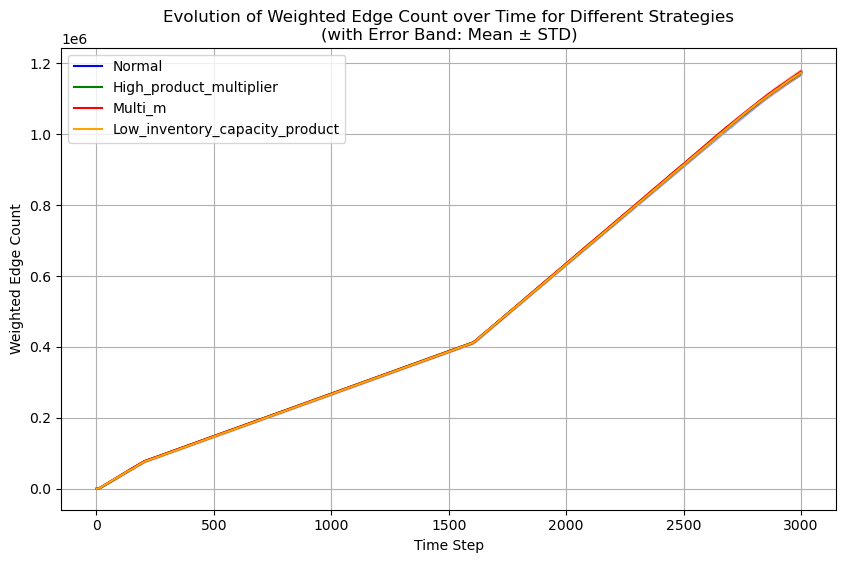

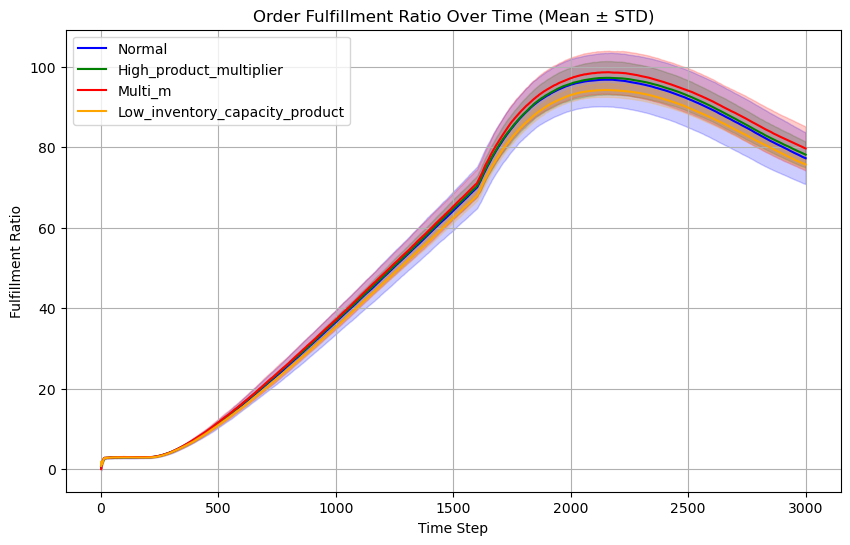

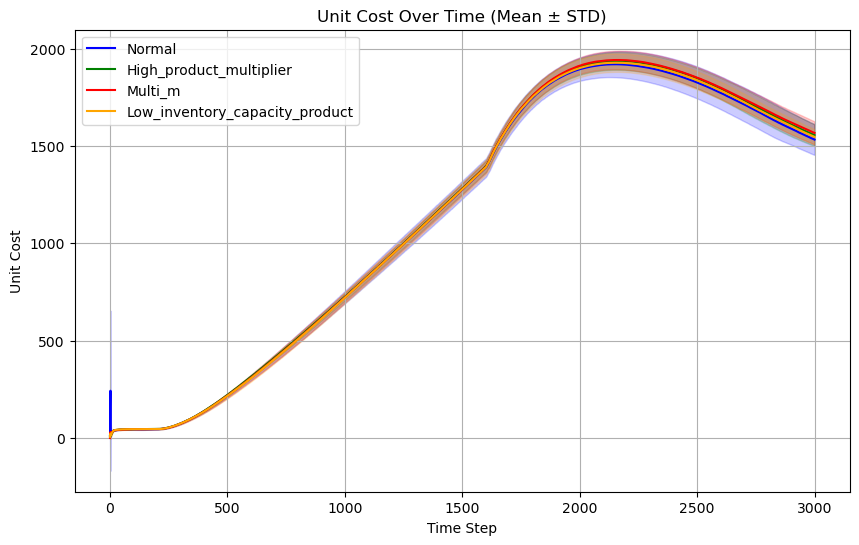

In [61]:
#product capacity change
def run_scenario(scenario_name, change_schedule, total_steps=3000, num_reps=5):
    print(f"Running scenario: {scenario_name}")
    results = run_simulation_with_param_changes(
        heterogeneous=True,
        cust_demand_multiplier=1.0,
        m_production_capacity=120,
        m_inventory_capacity_product=300,
        m_inventory_capacity_material=600,
        s_material_capacity=400,
        m_cap_mode="heterogeneous",
        logistics_speed=2.0,
        rm_procurement_mode="gap_based",
        rm_reorder_point=300,
        rm_reorder_target=600,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.1,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=3000,   # ✅ 动态传入
        num_reps=5,         # ✅ 动态传入
        change_schedule=change_schedule,
        return_model=False
    )

    (
        mean_prod_ratio,
        mean_unit_cost,
        mean_edge_series,
        std_edge_series,
        phase_metrics,
        mean_ratio_series,
        std_ratio_series,
        mean_uc_series,
        std_uc_series
    ) = results

    points = sorted([p for p in change_schedule.keys() if p <= total_steps] + [total_steps])
    print(f"—— Per-Phase Metrics for {scenario_name} ——")
    for idx, step in enumerate(points):
        r, uc_phase, completed_count = phase_metrics[idx]
        print(f" Step {step:>5}:   Ratio = {r:.3f},   UnitCost = {uc_phase:.3f},   Completed = {completed_count}")

    return {
        "mean_ratio": mean_prod_ratio,
        "mean_unit_cost": mean_unit_cost,
        "mean_edge_series": mean_edge_series,
        "std_edge_series": std_edge_series,
        "phase_metrics": phase_metrics,
        "mean_ratio_series": mean_ratio_series,
        "std_ratio_series": std_ratio_series,
        "mean_uc_series": mean_uc_series,
        "std_uc_series": std_uc_series
    }


change_schedule_A = {
    200: {"m_production_capacity": 40},
    1600: {"m_production_capacity": 120}
    
}
change_schedule_B = {
    200: {"m_production_capacity": 40},
    800: {"rm_produce_multiplier": 1.5},
    1600: {"m_production_capacity": 120}
}
change_schedule_C = {
    200: {"m_production_capacity": 40},
    800: {"product_order_mode":"multi_m"},
    1600: {"m_production_capacity": 120}
}
change_schedule_D = {
    200: {"m_production_capacity": 40},
    800: {"m_inventory_capacity_product":100},
    1600: {"m_production_capacity": 120}
}


total_steps = 3000

# 分别运行 3 个不同场景
results_A = run_scenario("Strategy A", change_schedule_A)
results_B = run_scenario("Strategy B", change_schedule_B)
results_C = run_scenario("Strategy C", change_schedule_C)
results_D = run_scenario("Strategy D", change_schedule_D)
time_steps = np.arange(1, total_steps + 1)

# 从各个策略的 simulation 返回结果中提取 weighted edge count 的均值和标准差
# 假设 run_scenario 返回的结果格式为：
# (mean_cap, mean_prod_ratio, mean_statusN, mean_unit_cost, mean_edge_series, std_edge_series)
mean_edge_series_A = results_A["mean_edge_series"]
std_edge_series_A = results_A["std_edge_series"]

mean_edge_series_B = results_B["mean_edge_series"]
std_edge_series_B = results_B["std_edge_series"]

mean_edge_series_C = results_C["mean_edge_series"]
std_edge_series_C = results_C["std_edge_series"]

mean_edge_series_D = results_D["mean_edge_series"]
std_edge_series_D = results_D["std_edge_series"]

plt.figure(figsize=(10, 6))
# 绘制 Strategy A 的曲线和误差带
plt.plot(time_steps, mean_edge_series_A, label="Normal", color="blue")
plt.fill_between(time_steps,
                 mean_edge_series_A - std_edge_series_A,
                 mean_edge_series_A + std_edge_series_A,
                 color="blue", alpha=0.2)

# 绘制 Strategy B 的曲线和误差带
plt.plot(time_steps, mean_edge_series_B, label="High_product_multiplier", color="green")
plt.fill_between(time_steps,
                 mean_edge_series_B - std_edge_series_B,
                 mean_edge_series_B + std_edge_series_B,
                 color="green", alpha=0.2)

# 绘制 Strategy C 的曲线和误差带
plt.plot(time_steps, mean_edge_series_C, label="Multi_m", color="red")
plt.fill_between(time_steps,
                 mean_edge_series_C - std_edge_series_C,
                 mean_edge_series_C + std_edge_series_C,
                 color="red", alpha=0.2)

# 绘制 Strategy D 的曲线和误差带
plt.plot(time_steps, mean_edge_series_D, label="Low_inventory_capacity_product", color="orange")
plt.fill_between(time_steps,
                 mean_edge_series_D - std_edge_series_D,
                 mean_edge_series_D + std_edge_series_D,
                 color="orange", alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count over Time for Different Strategies\n(with Error Band: Mean ± STD)")
plt.legend()
plt.grid(True)
plt.show()

# Fulfillment Ratio 曲线
plt.figure(figsize=(10, 6))
plt.plot(time_steps, results_A["mean_ratio_series"], label="Normal", color="blue")
plt.fill_between(time_steps,
                 results_A["mean_ratio_series"] - results_A["std_ratio_series"],
                 results_A["mean_ratio_series"] + results_A["std_ratio_series"],
                 color="blue", alpha=0.2)

plt.plot(time_steps, results_B["mean_ratio_series"], label="High_product_multiplier", color="green")
plt.fill_between(time_steps,
                 results_B["mean_ratio_series"] - results_B["std_ratio_series"],
                 results_B["mean_ratio_series"] + results_B["std_ratio_series"],
                 color="green", alpha=0.2)

plt.plot(time_steps, results_C["mean_ratio_series"], label="Multi_m", color="red")
plt.fill_between(time_steps,
                 results_C["mean_ratio_series"] - results_C["std_ratio_series"],
                 results_C["mean_ratio_series"] + results_C["std_ratio_series"],
                 color="red", alpha=0.2)

plt.plot(time_steps, results_D["mean_ratio_series"], label="Low_inventory_capacity_product", color="orange")
plt.fill_between(time_steps,
                 results_D["mean_ratio_series"] - results_D["std_ratio_series"],
                 results_D["mean_ratio_series"] + results_D["std_ratio_series"],
                 color="orange", alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Fulfillment Ratio")
plt.title("Order Fulfillment Ratio Over Time (Mean ± STD)")
plt.grid(True)
plt.legend()
plt.show()

# Unit Cost 曲线
plt.figure(figsize=(10, 6))
plt.plot(time_steps, results_A["mean_uc_series"], label="Normal", color="blue")
plt.fill_between(time_steps,
                 results_A["mean_uc_series"] - results_A["std_uc_series"],
                 results_A["mean_uc_series"] + results_A["std_uc_series"],
                 color="blue", alpha=0.2)

plt.plot(time_steps, results_B["mean_uc_series"], label="High_product_multiplier", color="green")
plt.fill_between(time_steps,
                 results_B["mean_uc_series"] - results_B["std_uc_series"],
                 results_B["mean_uc_series"] + results_B["std_uc_series"],
                 color="green", alpha=0.2)

plt.plot(time_steps, results_C["mean_uc_series"], label="Multi_m", color="red")
plt.fill_between(time_steps,
                 results_C["mean_uc_series"] - results_C["std_uc_series"],
                 results_C["mean_uc_series"] + results_C["std_uc_series"],
                 color="red", alpha=0.2)

plt.plot(time_steps, results_D["mean_uc_series"], label="Low_inventory_capacity_product", color="orange")
plt.fill_between(time_steps,
                 results_D["mean_uc_series"] - results_D["std_uc_series"],
                 results_D["mean_uc_series"] + results_D["std_uc_series"],
                 color="orange", alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Unit Cost")
plt.title("Unit Cost Over Time (Mean ± STD)")
plt.grid(True)
plt.legend()
plt.show()

Running scenario: Strategy A
—— Per-Phase Metrics for Strategy A ——
 Step   200:   Ratio = 4.415,   UnitCost = 67.999,   Completed = 72052.0
 Step  2000:   Ratio = 6.220,   UnitCost = 100.529,   Completed = 701514.0
 Step  3000:   Ratio = 6.564,   UnitCost = 107.629,   Completed = 398368.0
Running scenario: Strategy B
—— Per-Phase Metrics for Strategy B ——
 Step   200:   Ratio = 4.576,   UnitCost = 76.998,   Completed = 73900.0
 Step   600:   Ratio = 4.430,   UnitCost = 73.399,   Completed = 153714.0
 Step  2000:   Ratio = 8.158,   UnitCost = 148.297,   Completed = 545284.0
 Step  3000:   Ratio = 11.277,   UnitCost = 206.809,   Completed = 395907.0
Running scenario: Strategy C
—— Per-Phase Metrics for Strategy C ——
 Step   200:   Ratio = 4.809,   UnitCost = 77.731,   Completed = 76506.0
 Step   600:   Ratio = 5.121,   UnitCost = 86.158,   Completed = 155387.0
 Step  2000:   Ratio = 5.971,   UnitCost = 103.573,   Completed = 549539.0
 Step  3000:   Ratio = 5.438,   UnitCost = 93.001,   

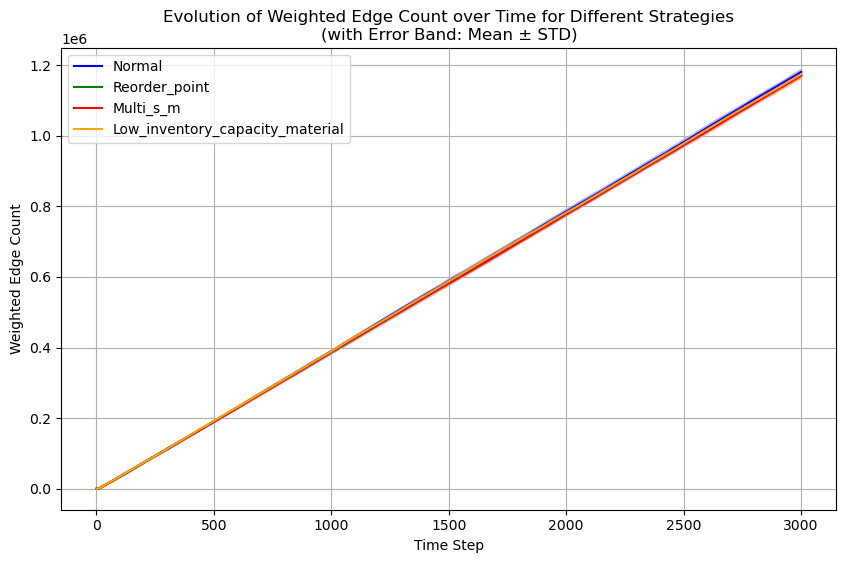

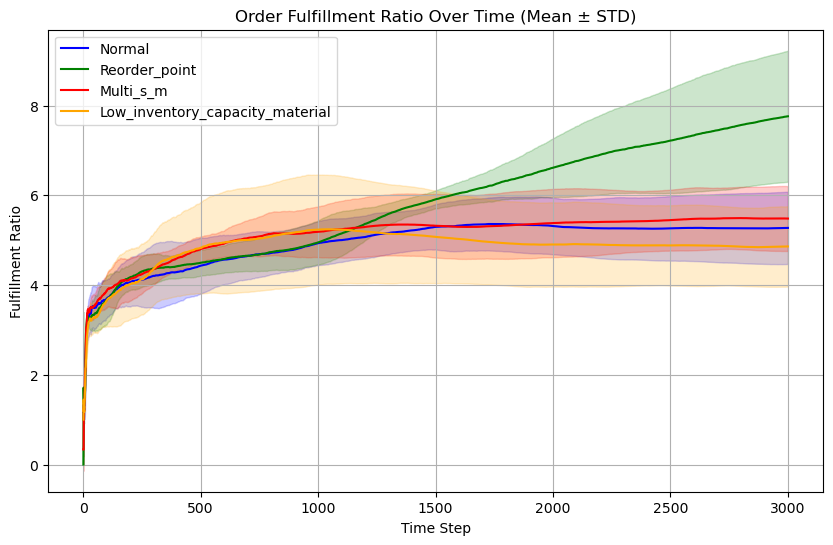

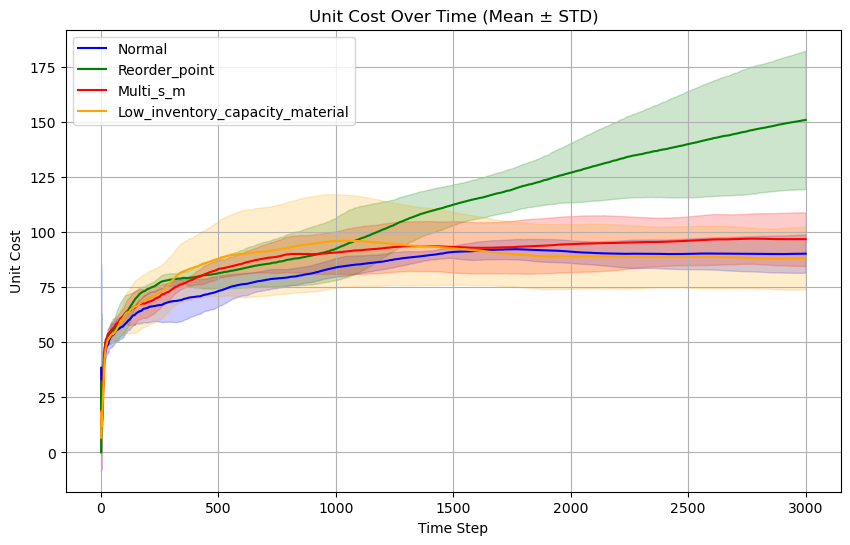

In [67]:
#logistics frozen
def run_scenario(scenario_name, change_schedule, total_steps=3000, num_reps=3):
    print(f"Running scenario: {scenario_name}")
    results = run_simulation_with_param_changes(
        heterogeneous=True,
        cust_demand_multiplier=1.0,
        m_production_capacity=80,
        m_inventory_capacity_product=300,
        m_inventory_capacity_material=600,
        s_material_capacity=400,
        m_cap_mode="heterogeneous",
        logistics_speed=2.0,
        rm_procurement_mode="gap_based",
        rm_reorder_point=300,
        rm_reorder_target=600,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.1,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=3000,   # ✅ 动态传入
        num_reps=3,         # ✅ 动态传入
        change_schedule=change_schedule,
        return_model=False
    )

    (
        mean_prod_ratio,
        mean_unit_cost,
        mean_edge_series,
        std_edge_series,
        phase_metrics,
        mean_ratio_series,
        std_ratio_series,
        mean_uc_series,
        std_uc_series
    ) = results

    points = sorted([p for p in change_schedule.keys() if p <= total_steps] + [total_steps])
    print(f"—— Per-Phase Metrics for {scenario_name} ——")
    for idx, step in enumerate(points):
        r, uc_phase, completed_count = phase_metrics[idx]
        print(f" Step {step:>5}:   Ratio = {r:.3f},   UnitCost = {uc_phase:.3f},   Completed = {completed_count}")

    return {
        "mean_ratio": mean_prod_ratio,
        "mean_unit_cost": mean_unit_cost,
        "mean_edge_series": mean_edge_series,
        "std_edge_series": std_edge_series,
        "phase_metrics": phase_metrics,
        "mean_ratio_series": mean_ratio_series,
        "std_ratio_series": std_ratio_series,
        "mean_uc_series": mean_uc_series,
        "std_uc_series": std_uc_series
    }
change_schedule_A = {
    200: {"logistics_speed": 0.5},
    2000: {"logistics_speed": 2}
}
change_schedule_B = {
    200: {"logistics_speed": 0.5},
    600: {"rm_procurement_mode":"reorder_point"},
    2000: {"logistics_speed": 2}
}
change_schedule_C = {
    200: {"logistics_speed": 0.5},
    600: {
        "maerial_order_mode": "multi_s",
        "product_order_mode":"multi_m"
    },
    2000: {"logistics_speed": 2}
}
change_schedule_D = {
    200: {"logistics_speed": 0.5},
    600: {"m_inventory_capacity_material":200},
    2000: {"logistics_speed": 2}
}

total_steps = 3000

# 分别运行 4 个不同场景
results_A = run_scenario("Strategy A", change_schedule_A)
results_B = run_scenario("Strategy B", change_schedule_B)
results_C = run_scenario("Strategy C", change_schedule_C)
results_D = run_scenario("Strategy D", change_schedule_D)

time_steps = np.arange(1, total_steps + 1)

# 从各个策略的 simulation 返回结果中提取 weighted edge count 的均值和标准差
# 假设 run_scenario 返回的结果格式为：
# (mean_cap, mean_prod_ratio, mean_statusN, mean_unit_cost, mean_edge_series, std_edge_series)
mean_edge_series_A = results_A["mean_edge_series"]
std_edge_series_A = results_A["std_edge_series"]

mean_edge_series_B = results_B["mean_edge_series"]
std_edge_series_B = results_B["std_edge_series"]

mean_edge_series_C = results_C["mean_edge_series"]
std_edge_series_C = results_C["std_edge_series"]

mean_edge_series_D = results_D["mean_edge_series"]
std_edge_series_D = results_D["std_edge_series"]


plt.figure(figsize=(10, 6))

# 绘制 Strategy A 的曲线和误差带
plt.plot(time_steps, mean_edge_series_A, label="Normal", color="blue")
plt.fill_between(time_steps,
                 mean_edge_series_A - std_edge_series_A,
                 mean_edge_series_A + std_edge_series_A,
                 color="blue", alpha=0.2)

# 绘制 Strategy B 的曲线和误差带
plt.plot(time_steps, mean_edge_series_B, label="Reorder_point", color="green")
plt.fill_between(time_steps,
                 mean_edge_series_B - std_edge_series_B,
                 mean_edge_series_B + std_edge_series_B,
                 color="green", alpha=0.2)

# 绘制 Strategy C 的曲线和误差带
plt.plot(time_steps, mean_edge_series_C, label="Multi_s_m", color="red")
plt.fill_between(time_steps,
                 mean_edge_series_C - std_edge_series_C,
                 mean_edge_series_C + std_edge_series_C,
                 color="red", alpha=0.2)

# 绘制 Strategy D 的曲线和误差带
plt.plot(time_steps, mean_edge_series_D, label="Low_inventory_capacity_material", color="orange")
plt.fill_between(time_steps,
                 mean_edge_series_D - std_edge_series_D,
                 mean_edge_series_D + std_edge_series_D,
                 color="orange", alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count over Time for Different Strategies\n(with Error Band: Mean ± STD)")
plt.legend()
plt.grid(True)
plt.show()

# Fulfillment Ratio 曲线
plt.figure(figsize=(10, 6))
plt.plot(time_steps, results_A["mean_ratio_series"], label="Normal", color="blue")
plt.fill_between(time_steps,
                 results_A["mean_ratio_series"] - results_A["std_ratio_series"],
                 results_A["mean_ratio_series"] + results_A["std_ratio_series"],
                 color="blue", alpha=0.2)

plt.plot(time_steps, results_B["mean_ratio_series"], label="Reorder_point", color="green")
plt.fill_between(time_steps,
                 results_B["mean_ratio_series"] - results_B["std_ratio_series"],
                 results_B["mean_ratio_series"] + results_B["std_ratio_series"],
                 color="green", alpha=0.2)

plt.plot(time_steps, results_C["mean_ratio_series"], label="Multi_s_m", color="red")
plt.fill_between(time_steps,
                 results_C["mean_ratio_series"] - results_C["std_ratio_series"],
                 results_C["mean_ratio_series"] + results_C["std_ratio_series"],
                 color="red", alpha=0.2)

plt.plot(time_steps, results_D["mean_ratio_series"], label="Low_inventory_capacity_material", color="orange")
plt.fill_between(time_steps,
                 results_D["mean_ratio_series"] - results_D["std_ratio_series"],
                 results_D["mean_ratio_series"] + results_D["std_ratio_series"],
                 color="orange", alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Fulfillment Ratio")
plt.title("Order Fulfillment Ratio Over Time (Mean ± STD)")
plt.grid(True)
plt.legend()
plt.show()

# Unit Cost 曲线
plt.figure(figsize=(10, 6))
plt.plot(time_steps, results_A["mean_uc_series"], label="Normal", color="blue")
plt.fill_between(time_steps,
                 results_A["mean_uc_series"] - results_A["std_uc_series"],
                 results_A["mean_uc_series"] + results_A["std_uc_series"],
                 color="blue", alpha=0.2)

plt.plot(time_steps, results_B["mean_uc_series"], label="Reorder_point", color="green")
plt.fill_between(time_steps,
                 results_B["mean_uc_series"] - results_B["std_uc_series"],
                 results_B["mean_uc_series"] + results_B["std_uc_series"],
                 color="green", alpha=0.2)

plt.plot(time_steps, results_C["mean_uc_series"], label="Multi_s_m", color="red")
plt.fill_between(time_steps,
                 results_C["mean_uc_series"] - results_C["std_uc_series"],
                 results_C["mean_uc_series"] + results_C["std_uc_series"],
                 color="red", alpha=0.2)
plt.plot(time_steps, results_D["mean_uc_series"], label="Low_inventory_capacity_material", color="orange")
plt.fill_between(time_steps,
                 results_D["mean_uc_series"] - results_D["std_uc_series"],
                 results_D["mean_uc_series"] + results_D["std_uc_series"],
                 color="orange", alpha=0.2)
plt.xlabel("Time Step")
plt.ylabel("Unit Cost")
plt.title("Unit Cost Over Time (Mean ± STD)")
plt.grid(True)
plt.legend()
plt.show()

Running scenario: Strategy A
—— Per-Phase Metrics for Strategy A ——
 Step   200:   Ratio = 4.239,   UnitCost = 72.951,   Completed = 74169.0
 Step  2000:   Ratio = 131.579,   UnitCost = 2584.266,   Completed = 767087.0
 Step  3000:   Ratio = 331.659,   UnitCost = 6490.103,   Completed = 424710.0
Running scenario: Strategy B
—— Per-Phase Metrics for Strategy B ——
 Step   200:   Ratio = 4.182,   UnitCost = 75.172,   Completed = 71382.0
 Step   600:   Ratio = 30.808,   UnitCost = 646.915,   Completed = 165763.0
 Step  2000:   Ratio = 89.892,   UnitCost = 1840.543,   Completed = 933482.0
 Step  3000:   Ratio = 102.971,   UnitCost = 2273.994,   Completed = 667703.0
Running scenario: Strategy C
—— Per-Phase Metrics for Strategy C ——
 Step   200:   Ratio = 3.300,   UnitCost = 53.846,   Completed = 73575.0
 Step   600:   Ratio = 27.787,   UnitCost = 566.565,   Completed = 176086.0
 Step  2000:   Ratio = 149.484,   UnitCost = 2998.229,   Completed = 614826.0
 Step  3000:   Ratio = 305.324,   Un

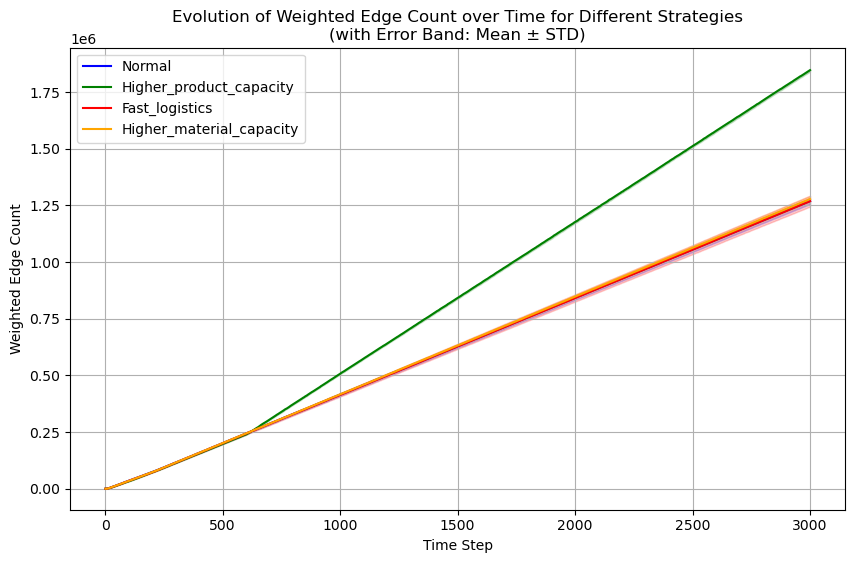

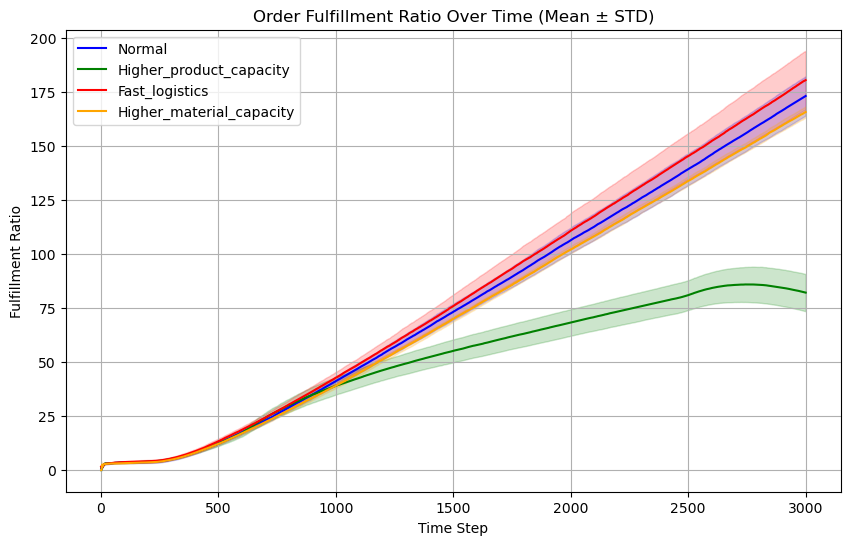

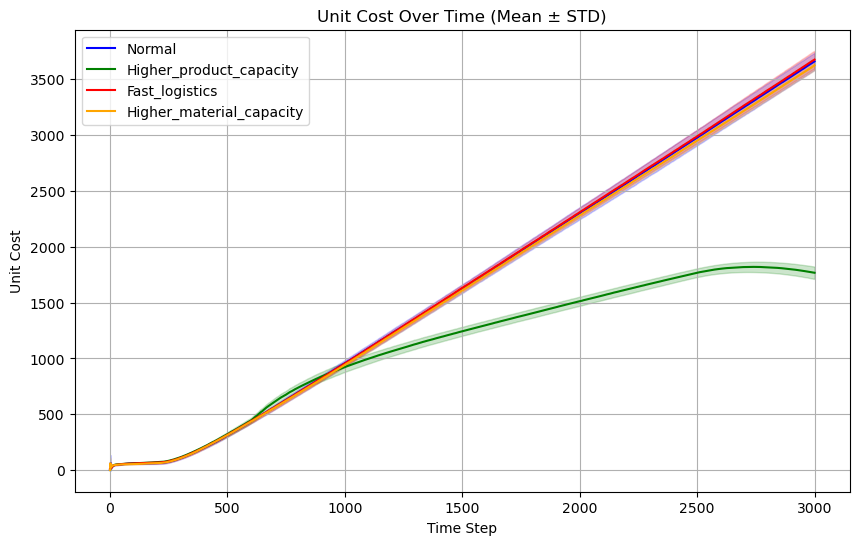

In [69]:
#demand increase
def run_scenario(scenario_name, change_schedule, total_steps=3000, num_reps=3):
    print(f"Running scenario: {scenario_name}")
    results = run_simulation_with_param_changes(
        heterogeneous=True,
        cust_demand_multiplier=1.0,
        m_production_capacity=80,
        m_inventory_capacity_product=300,
        m_inventory_capacity_material=600,
        s_material_capacity=400,
        m_cap_mode="heterogeneous",
        logistics_speed=2.0,
        rm_procurement_mode="gap_based",
        rm_reorder_point=300,
        rm_reorder_target=600,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.1,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=3000,   # ✅ 动态传入
        num_reps=3,         # ✅ 动态传入
        change_schedule=change_schedule,
        return_model=False
    )

    (
        mean_prod_ratio,
        mean_unit_cost,
        mean_edge_series,
        std_edge_series,
        phase_metrics,
        mean_ratio_series,
        std_ratio_series,
        mean_uc_series,
        std_uc_series
    ) = results

    points = sorted([p for p in change_schedule.keys() if p <= total_steps] + [total_steps])
    print(f"—— Per-Phase Metrics for {scenario_name} ——")
    for idx, step in enumerate(points):
        r, uc_phase, completed_count = phase_metrics[idx]
        print(f" Step {step:>5}:   Ratio = {r:.3f},   UnitCost = {uc_phase:.3f},   Completed = {completed_count}")

    return {
        "mean_ratio": mean_prod_ratio,
        "mean_unit_cost": mean_unit_cost,
        "mean_edge_series": mean_edge_series,
        "std_edge_series": std_edge_series,
        "phase_metrics": phase_metrics,
        "mean_ratio_series": mean_ratio_series,
        "std_ratio_series": std_ratio_series,
        "mean_uc_series": mean_uc_series,
        "std_uc_series": std_uc_series
    }
change_schedule_A = {
    200: {"cust_demand_multiplier": 2},
    2000:{"cust_demand_multiplier": 1}
}
change_schedule_B = {
    200: {"cust_demand_multiplier": 2},
    600: {"m_production_capacity": 160},
    2000:{"cust_demand_multiplier": 1}
}
change_schedule_C = {
    200: {"cust_demand_multiplier": 2},
    600: {"logistics_speed":4},
    2000:{"cust_demand_multiplier": 1}
}
change_schedule_D = {
    200: {"cust_demand_multiplier": 2},
    600: {"s_material_capacity":800},
    2000:{"cust_demand_multiplier": 1}
}


total_steps = 3000

# 分别运行 4 个不同场景
results_A = run_scenario("Strategy A", change_schedule_A)
results_B = run_scenario("Strategy B", change_schedule_B)
results_C = run_scenario("Strategy C", change_schedule_C)
results_D = run_scenario("Strategy D", change_schedule_D)

time_steps = np.arange(1, total_steps + 1)

# 从各个策略的 simulation 返回结果中提取 weighted edge count 的均值和标准差
# 假设 run_scenario 返回的结果格式为：
# (mean_cap, mean_prod_ratio, mean_statusN, mean_unit_cost, mean_edge_series, std_edge_series)
mean_edge_series_A = results_A["mean_edge_series"]
std_edge_series_A = results_A["std_edge_series"]

mean_edge_series_B = results_B["mean_edge_series"]
std_edge_series_B = results_B["std_edge_series"]

mean_edge_series_C = results_C["mean_edge_series"]
std_edge_series_C = results_C["std_edge_series"]

mean_edge_series_D = results_D["mean_edge_series"]
std_edge_series_D = results_D["std_edge_series"]

plt.figure(figsize=(10, 6))

# 绘制 Strategy A 的曲线和误差带
plt.plot(time_steps, mean_edge_series_A, label="Normal", color="blue")
plt.fill_between(time_steps,
                 mean_edge_series_A - std_edge_series_A,
                 mean_edge_series_A + std_edge_series_A,
                 color="blue", alpha=0.2)

# 绘制 Strategy B 的曲线和误差带
plt.plot(time_steps, mean_edge_series_B, label="Higher_product_capacity", color="green")
plt.fill_between(time_steps,
                 mean_edge_series_B - std_edge_series_B,
                 mean_edge_series_B + std_edge_series_B,
                 color="green", alpha=0.2)

# 绘制 Strategy C 的曲线和误差带
plt.plot(time_steps, mean_edge_series_C, label="Fast_logistics", color="red")
plt.fill_between(time_steps,
                 mean_edge_series_C - std_edge_series_C,
                 mean_edge_series_C + std_edge_series_C,
                 color="red", alpha=0.2)

# 绘制 Strategy D 的曲线和误差带
plt.plot(time_steps, mean_edge_series_D, label="Higher_material_capacity", color="orange")
plt.fill_between(time_steps,
                 mean_edge_series_D - std_edge_series_D,
                 mean_edge_series_D + std_edge_series_D,
                 color="orange", alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Evolution of Weighted Edge Count over Time for Different Strategies\n(with Error Band: Mean ± STD)")
plt.legend()
plt.grid(True)
plt.show()

# Fulfillment Ratio 曲线
plt.figure(figsize=(10, 6))
plt.plot(time_steps, results_A["mean_ratio_series"], label="Normal", color="blue")
plt.fill_between(time_steps,
                 results_A["mean_ratio_series"] - results_A["std_ratio_series"],
                 results_A["mean_ratio_series"] + results_A["std_ratio_series"],
                 color="blue", alpha=0.2)

plt.plot(time_steps, results_B["mean_ratio_series"], label="Higher_product_capacity", color="green")
plt.fill_between(time_steps,
                 results_B["mean_ratio_series"] - results_B["std_ratio_series"],
                 results_B["mean_ratio_series"] + results_B["std_ratio_series"],
                 color="green", alpha=0.2)

plt.plot(time_steps, results_C["mean_ratio_series"], label="Fast_logistics", color="red")
plt.fill_between(time_steps,
                 results_C["mean_ratio_series"] - results_C["std_ratio_series"],
                 results_C["mean_ratio_series"] + results_C["std_ratio_series"],
                 color="red", alpha=0.2)

plt.plot(time_steps, results_D["mean_ratio_series"], label="Higher_material_capacity", color="orange")
plt.fill_between(time_steps,
                 results_D["mean_ratio_series"] - results_D["std_ratio_series"],
                 results_D["mean_ratio_series"] + results_D["std_ratio_series"],
                 color="orange", alpha=0.2)

plt.xlabel("Time Step")
plt.ylabel("Fulfillment Ratio")
plt.title("Order Fulfillment Ratio Over Time (Mean ± STD)")
plt.grid(True)
plt.legend()
plt.show()

# Unit Cost 曲线
plt.figure(figsize=(10, 6))
plt.plot(time_steps, results_A["mean_uc_series"], label="Normal", color="blue")
plt.fill_between(time_steps,
                 results_A["mean_uc_series"] - results_A["std_uc_series"],
                 results_A["mean_uc_series"] + results_A["std_uc_series"],
                 color="blue", alpha=0.2)

plt.plot(time_steps, results_B["mean_uc_series"], label="Higher_product_capacity", color="green")
plt.fill_between(time_steps,
                 results_B["mean_uc_series"] - results_B["std_uc_series"],
                 results_B["mean_uc_series"] + results_B["std_uc_series"],
                 color="green", alpha=0.2)

plt.plot(time_steps, results_C["mean_uc_series"], label="Fast_logistics", color="red")
plt.fill_between(time_steps,
                 results_C["mean_uc_series"] - results_C["std_uc_series"],
                 results_C["mean_uc_series"] + results_C["std_uc_series"],
                 color="red", alpha=0.2)
plt.plot(time_steps, results_D["mean_uc_series"], label="Higher_material_capacity", color="orange")
plt.fill_between(time_steps,
                 results_D["mean_uc_series"] - results_D["std_uc_series"],
                 results_D["mean_uc_series"] + results_D["std_uc_series"],
                 color="orange", alpha=0.2)
plt.xlabel("Time Step")
plt.ylabel("Unit Cost")
plt.title("Unit Cost Over Time (Mean ± STD)")
plt.grid(True)
plt.legend()
plt.show()

Scan s_mat (High Demand): 100%|█████████████████████████████████████████████████████| 17/17 [1:02:39<00:00, 221.13s/it]


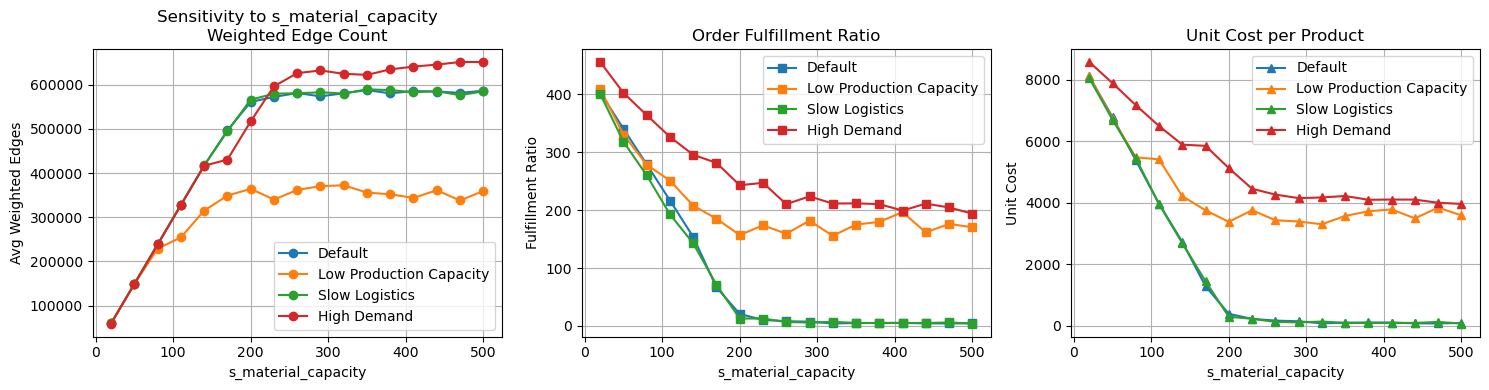

In [70]:
#sensetive for s_mat
from tqdm import tqdm

total_steps = 3000
num_reps    = 1

# 定义三个“静态扰动”场景
scenarios = {
    "Default":       {},
    "Low Production Capacity":{"m_production_capacity": 40},
    "Slow Logistics":{"logistics_speed": 0.5},
    "High Demand":   {"cust_demand_multiplier": 2.0}
}

# 要扫描的参数范围
s_mat_range  = [20, 50, 80, 110, 140, 170, 200,230,260,290,320,350,380,410,440,470,500]

# 存储结果结构
metrics_smat  = { name: [] for name in scenarios }

def eval_static(base_params, override_params):
    """
    base_params: 场景级别的 override dict
    override_params: 本次扫描时要改动的 dict
    """
    # 1) 全部默认参数
    all_params = dict(
        heterogeneous=True,
        cust_demand_multiplier=1.0,
        m_production_capacity=80,        # baseline
        m_inventory_capacity_product=300,
        m_inventory_capacity_material=600,
        s_material_capacity=400,         # baseline
        m_cap_mode="heterogeneous",
        logistics_speed=2.0,
        rm_procurement_mode="gap_based",
        rm_reorder_point=100,
        rm_reorder_target=300,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.1,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=total_steps,
        num_reps=num_reps,
        change_schedule=None,
        return_model=True,
    )
    # 2) 场景级 override
    all_params.update(base_params)
    # 3) 本次扫描 override
    all_params.update(override_params)

    # 4) 一次性调用，不会再出现同名参数冲突
    _, (mean_ratio, mean_uc, mean_edge_series, *_ ) = run_simulation_with_param_changes(**all_params)
    return np.mean(mean_edge_series), mean_ratio, mean_uc

# —— 扫描 s_material_capacity —— 
for name, base_params in scenarios.items():
    for smc in tqdm(s_mat_range, desc=f"Scan s_mat ({name})"):
        avg_edge, ratio, uc = eval_static(
            base_params,
            {"s_material_capacity": smc}
        )
        metrics_smat[name].append((smc, avg_edge, ratio, uc))


# —— 画图函数 —— 
def plot_three_subplots(metrics, param_label, title_prefix):
    xs = [t[0] for t in next(iter(metrics.values()))]
    fig, axes = plt.subplots(1, 3, figsize=(15,4), sharex=True)

    # 子图1: 加权边数
    ax = axes[0]
    for name,data in metrics.items():
        ax.plot(xs, [t[1] for t in data], marker='o', label=name)
    ax.set(xlabel=param_label, ylabel="Avg Weighted Edges",
           title=title_prefix+"\nWeighted Edge Count")
    ax.grid(); ax.legend()

    # 子图2: 履约率
    ax = axes[1]
    for name,data in metrics.items():
        ax.plot(xs, [t[2] for t in data], marker='s', label=name)
    ax.set(xlabel=param_label, ylabel="Fulfillment Ratio",
           title="Order Fulfillment Ratio")
    ax.grid(); ax.legend()

    # 子图3: 单位成本
    ax = axes[2]
    for name,data in metrics.items():
        ax.plot(xs, [t[3] for t in data], marker='^', label=name)
    ax.set(xlabel=param_label, ylabel="Unit Cost",
           title="Unit Cost per Product")
    ax.grid(); ax.legend()

    plt.tight_layout()
    plt.show()

plot_three_subplots(metrics_smat,
                   "s_material_capacity",
                   "Sensitivity to s_material_capacity")

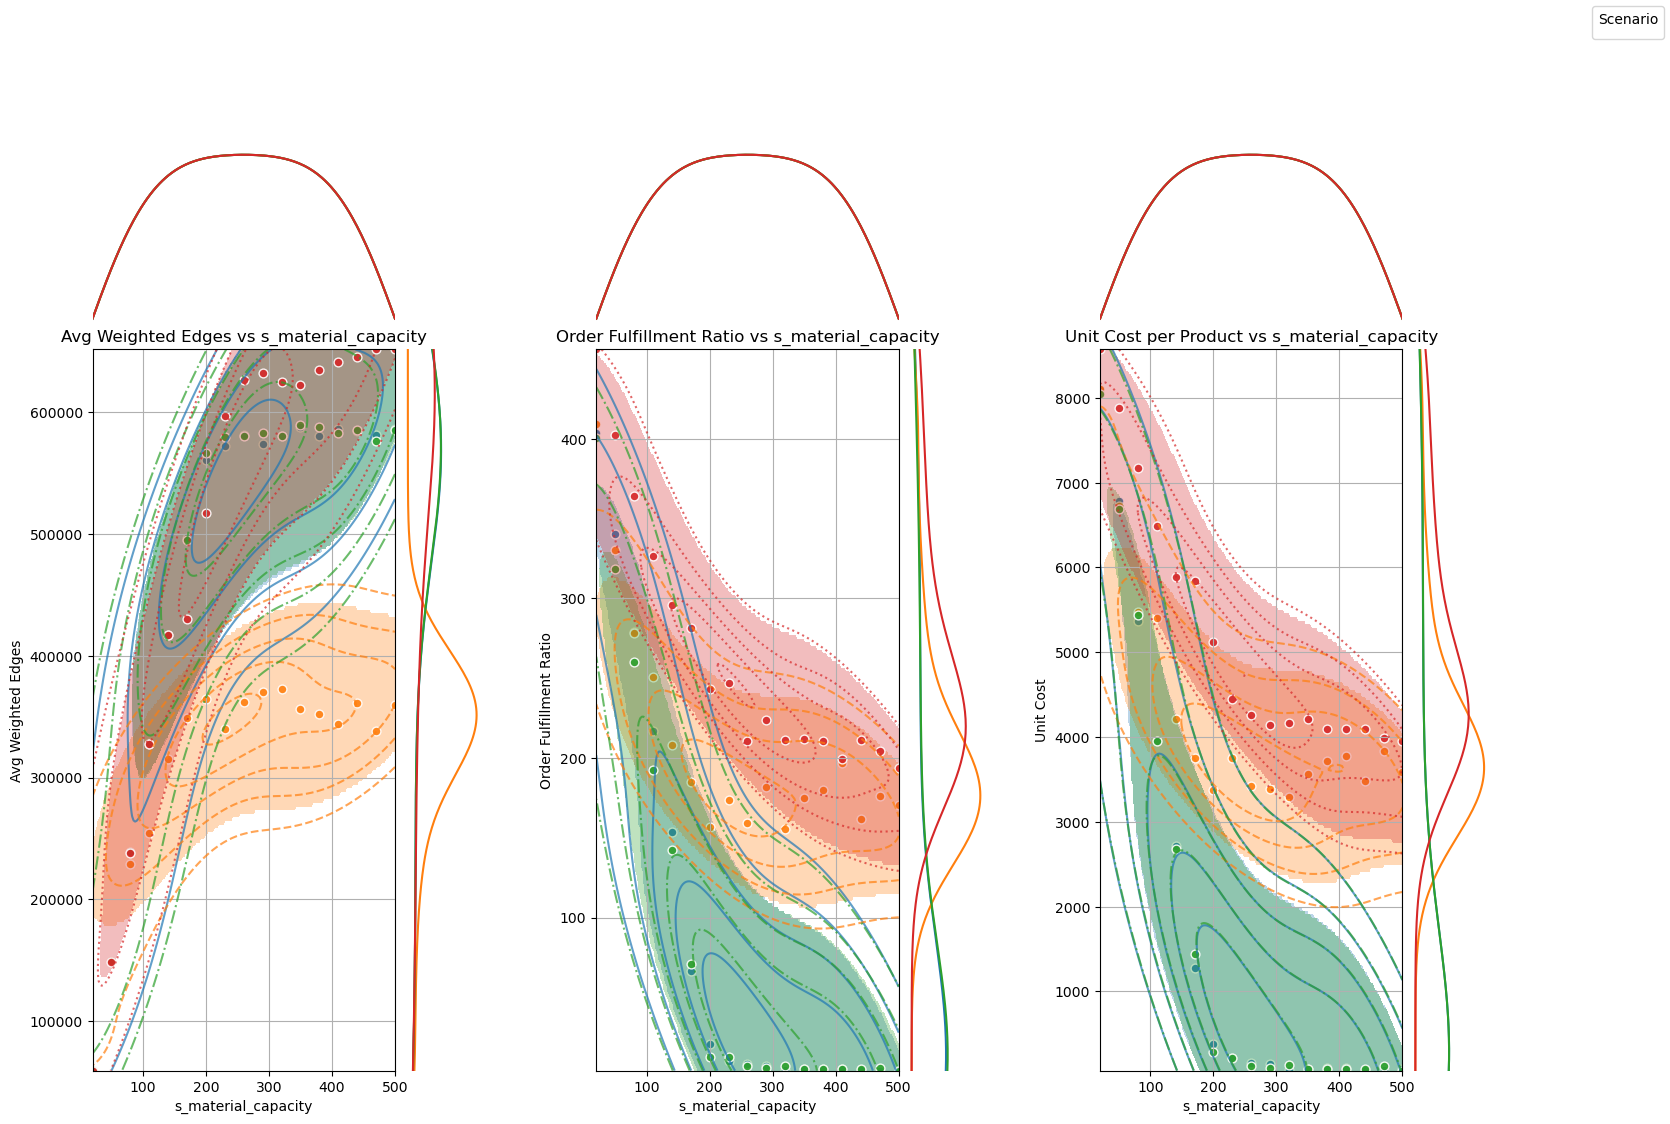

In [72]:
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde

# 场景及样式
scenarios  = ["Default", "Low Production Capacity", "Slow Logistics", "High Demand"]
colors     = ["C0", "C1", "C2","C3"]
linestyles = ['-', '--', '-.', ':']

# 指定六个子图： (metrics_dict, y_index, x_label, y_label, title)
combos = [
    (metrics_smat, 1, 's_material_capacity', 'Avg Weighted Edges',
     'Avg Weighted Edges vs s_material_capacity'),
    (metrics_smat, 2, 's_material_capacity', 'Order Fulfillment Ratio',
     'Order Fulfillment Ratio vs s_material_capacity'),
    (metrics_smat, 3, 's_material_capacity', 'Unit Cost',
     'Unit Cost per Product vs s_material_capacity'),
]

fig = plt.figure(figsize=(18, 12))
outer = GridSpec(1, 3, wspace=0.3, hspace=0.3)

for idx, (metrics_dict, yi, xlab, ylab, title) in enumerate(combos):
    row, col = divmod(idx, 3)
    inner = outer[row, col].subgridspec(
        2, 2,
        width_ratios=(4, 1),
        height_ratios=(1, 4),
        wspace=0.05, hspace=0.05
    )

    ax_main = fig.add_subplot(inner[1, 0])
    ax_x    = fig.add_subplot(inner[0, 0], sharex=ax_main)
    ax_y    = fig.add_subplot(inner[1, 1], sharey=ax_main)

    # 先拿到本图所有场景 x,y 的范围，做公共网格
    all_x = np.hstack([ [t[0] for t in metrics_dict[s]] for s in scenarios ])
    all_y = np.hstack([ [t[yi] for t in metrics_dict[s]] for s in scenarios ])
    xi, yi_grid = np.mgrid[
        all_x.min():all_x.max():200j,
        all_y.min():all_y.max():200j
    ]

    for scen, c, ls in zip(scenarios, colors, linestyles):
        arr = metrics_dict[scen]
        x   = np.array([t[0] for t in arr])
        y   = np.array([t[yi] for t in arr])

        # KDE & 密度矩阵
        kde = gaussian_kde(np.vstack([x, y]))
        zi  = kde(np.vstack([xi.ravel(), yi_grid.ravel()])).reshape(xi.shape)

        # 只填高于 75th 百分位的区域
        thresh  = np.percentile(zi, 75)
        zi_mask = np.ma.masked_less(zi, thresh)
        ax_main.contourf(
            xi, yi_grid, zi_mask,
            levels=[thresh, zi.max()],
            colors=[c],
            alpha=0.3,
            extend='neither'
        )
        # 叠加等高线
        ax_main.contour(
            xi, yi_grid, zi,
            levels=5,
            colors=[c],
            linestyles=ls,
            alpha=0.7
        )
        # 散点
        ax_main.scatter(
            x, y,
            c=c,
            edgecolor='white',
            s=40,
            label=scen if idx==0 else "",  # 只在第一个子图标一次
            alpha=0.9
        )
        # 上方边缘密度
        kde_x = gaussian_kde(x)
        xs    = np.linspace(all_x.min(), all_x.max(), 200)
        ax_x.plot(xs, kde_x(xs), color=c)
        # 右侧边缘密度
        kde_y = gaussian_kde(y)
        ys    = np.linspace(all_y.min(), all_y.max(), 200)
        ax_y.plot(kde_y(ys), ys, color=c)

    # 轴和标题
    ax_main.set_xlabel(xlab)
    ax_main.set_ylabel(ylab)
    ax_main.set_title(title)
    ax_main.grid(True)

    # 隐藏空轴刻度
    ax_x.axis('off')
    ax_y.axis('off')

# 总图例放在右上角
handles, labels = ax_main.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='Scenario')

plt.show()

Scan m_prod (High Demand): 100%|██████████████████████████████████████████████████████| 17/17 [58:00<00:00, 204.72s/it]


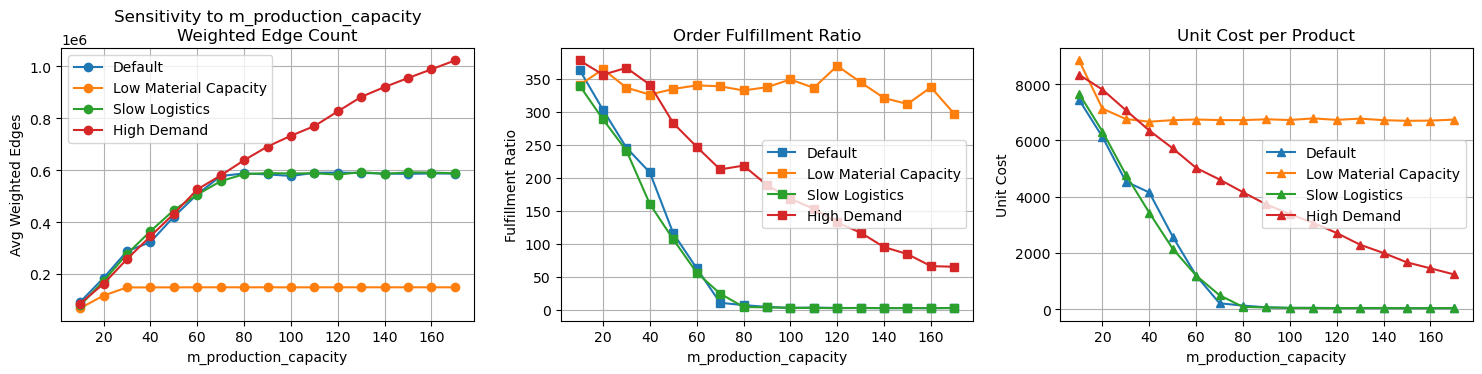

In [73]:
#sensetive for m_prod
from tqdm import tqdm

total_steps = 3000
num_reps    = 1

# 定义三个“静态扰动”场景
scenarios = {
    "Default":       {},
    "Low Material Capacity":{"s_material_capacity": 50},   
    "Slow Logistics":{"logistics_speed": 0.5},
    "High Demand":   {"cust_demand_multiplier": 2.0}
}

# 要扫描的参数范围
m_prod_range = [10, 20, 30, 40, 50, 60,70,80,90,100, 110, 120,130,140,150,160,170]


# 存储结果结构
metrics_mprod = { name: [] for name in scenarios }

def eval_static(base_params, override_params):
    """
    base_params: 场景级别的 override dict
    override_params: 本次扫描时要改动的 dict
    """
    # 1) 全部默认参数
    all_params = dict(
        heterogeneous=True,
        cust_demand_multiplier=1.0,
        m_production_capacity=80,        # baseline
        m_inventory_capacity_product=300,
        m_inventory_capacity_material=600,
        s_material_capacity=400,         # baseline
        m_cap_mode="heterogeneous",
        logistics_speed=2.0,
        rm_procurement_mode="gap_based",
        rm_reorder_point=100,
        rm_reorder_target=300,
        rm_purchase_multiplier=1.2,
        rm_produce_multiplier=1.1,
        product_order_mode="normal",
        material_order_mode="normal",
        total_steps=total_steps,
        num_reps=num_reps,
        change_schedule=None,
        return_model=True,
    )
    # 2) 场景级 override
    all_params.update(base_params)
    # 3) 本次扫描 override
    all_params.update(override_params)

    # 4) 一次性调用，不会再出现同名参数冲突
    _, (mean_ratio, mean_uc, mean_edge_series, *_ ) = run_simulation_with_param_changes(**all_params)
    return np.mean(mean_edge_series), mean_ratio, mean_uc


# —— 扫描 m_production_capacity —— 
for name, base_params in scenarios.items():
    for mpc in tqdm(m_prod_range, desc=f"Scan m_prod ({name})"):
        avg_edge, ratio, uc = eval_static(
            base_params,
            {"m_production_capacity": mpc}
        )
        metrics_mprod[name].append((mpc, avg_edge, ratio, uc))


# —— 画图函数 —— 
def plot_three_subplots(metrics, param_label, title_prefix):
    xs = [t[0] for t in next(iter(metrics.values()))]
    fig, axes = plt.subplots(1, 3, figsize=(15,4), sharex=True)

    # 子图1: 加权边数
    ax = axes[0]
    for name,data in metrics.items():
        ax.plot(xs, [t[1] for t in data], marker='o', label=name)
    ax.set(xlabel=param_label, ylabel="Avg Weighted Edges",
           title=title_prefix+"\nWeighted Edge Count")
    ax.grid(); ax.legend()

    # 子图2: 履约率
    ax = axes[1]
    for name,data in metrics.items():
        ax.plot(xs, [t[2] for t in data], marker='s', label=name)
    ax.set(xlabel=param_label, ylabel="Fulfillment Ratio",
           title="Order Fulfillment Ratio")
    ax.grid(); ax.legend()

    # 子图3: 单位成本
    ax = axes[2]
    for name,data in metrics.items():
        ax.plot(xs, [t[3] for t in data], marker='^', label=name)
    ax.set(xlabel=param_label, ylabel="Unit Cost",
           title="Unit Cost per Product")
    ax.grid(); ax.legend()

    plt.tight_layout()
    plt.show()

# 绘制
plot_three_subplots(metrics_mprod,
                   "m_production_capacity",
                   "Sensitivity to m_production_capacity")

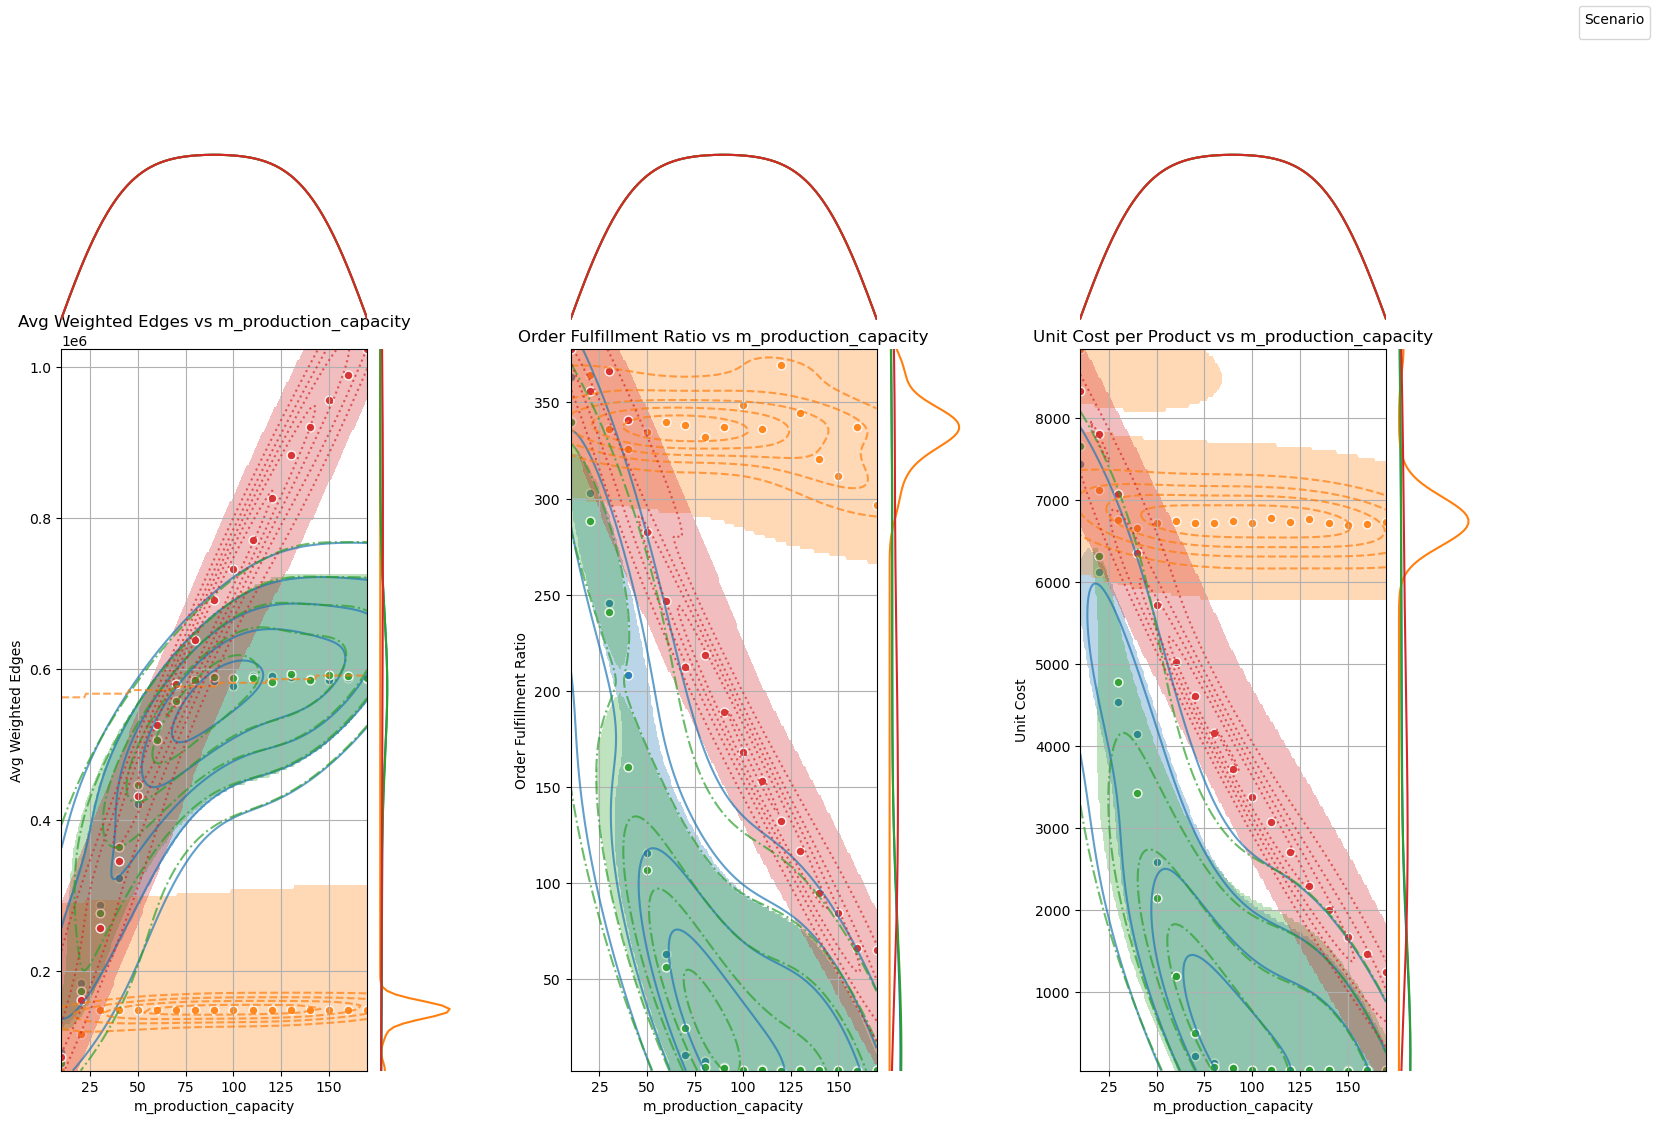

In [79]:
# 场景及样式
scenarios  = ["Default", "Low Material Capacity", "Slow Logistics", "High Demand"]
colors     = ["C0", "C1", "C2","C3"]
linestyles = ['-', '--', '-.',':']

# 指定六个子图： (metrics_dict, y_index, x_label, y_label, title)
combos = [
    (metrics_mprod, 1, 'm_production_capacity', 'Avg Weighted Edges',
     'Avg Weighted Edges vs m_production_capacity'),
    (metrics_mprod, 2, 'm_production_capacity', 'Order Fulfillment Ratio',
     'Order Fulfillment Ratio vs m_production_capacity'),
    (metrics_mprod, 3, 'm_production_capacity', 'Unit Cost',
     'Unit Cost per Product vs m_production_capacity'),
]

fig = plt.figure(figsize=(18.2, 12))
outer = GridSpec(1, 3, wspace=0.3, hspace=0.3)

for idx, (metrics_dict, yi, xlab, ylab, title) in enumerate(combos):
    row, col = divmod(idx, 3)
    inner = outer[row, col].subgridspec(
        2, 2,
        width_ratios=(4, 1),
        height_ratios=(1, 4),
        wspace=0.05, hspace=0.05
    )

    ax_main = fig.add_subplot(inner[1, 0])
    ax_x    = fig.add_subplot(inner[0, 0], sharex=ax_main)
    ax_y    = fig.add_subplot(inner[1, 1], sharey=ax_main)

    # 先拿到本图所有场景 x,y 的范围，做公共网格
    all_x = np.hstack([ [t[0] for t in metrics_dict[s]] for s in scenarios ])
    all_y = np.hstack([ [t[yi] for t in metrics_dict[s]] for s in scenarios ])
    xi, yi_grid = np.mgrid[
        all_x.min():all_x.max():200j,
        all_y.min():all_y.max():200j
    ]

    for scen, c, ls in zip(scenarios, colors, linestyles):
        arr = metrics_dict[scen]
        x   = np.array([t[0] for t in arr])
        y   = np.array([t[yi] for t in arr])

        # KDE & 密度矩阵
        kde = gaussian_kde(np.vstack([x, y]))
        zi  = kde(np.vstack([xi.ravel(), yi_grid.ravel()])).reshape(xi.shape)

        # 只填高于 75th 百分位的区域
        thresh  = np.percentile(zi, 75)
        zi_mask = np.ma.masked_less(zi, thresh)
        ax_main.contourf(
            xi, yi_grid, zi_mask,
            levels=[thresh, zi.max()],
            colors=[c],
            alpha=0.3,
            extend='neither'
        )
        # 叠加等高线
        ax_main.contour(
            xi, yi_grid, zi,
            levels=5,
            colors=[c],
            linestyles=ls,
            alpha=0.7
        )
        # 散点
        ax_main.scatter(
            x, y,
            c=c,
            edgecolor='white',
            s=40,
            label=scen if idx==0 else "",  # 只在第一个子图标一次
            alpha=0.9
        )
        # 上方边缘密度
        kde_x = gaussian_kde(x)
        xs    = np.linspace(all_x.min(), all_x.max(), 200)
        ax_x.plot(xs, kde_x(xs), color=c)
        # 右侧边缘密度
        kde_y = gaussian_kde(y)
        ys    = np.linspace(all_y.min(), all_y.max(), 200)
        ax_y.plot(kde_y(ys), ys, color=c)

    # 轴和标题
    ax_main.set_xlabel(xlab)
    ax_main.set_ylabel(ylab)
    ax_main.set_title(title)
    ax_main.grid(True)

    # 隐藏空轴刻度
    ax_x.axis('off')
    ax_y.axis('off')

# 总图例放在右上角
handles, labels = ax_main.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='Scenario')

plt.show()

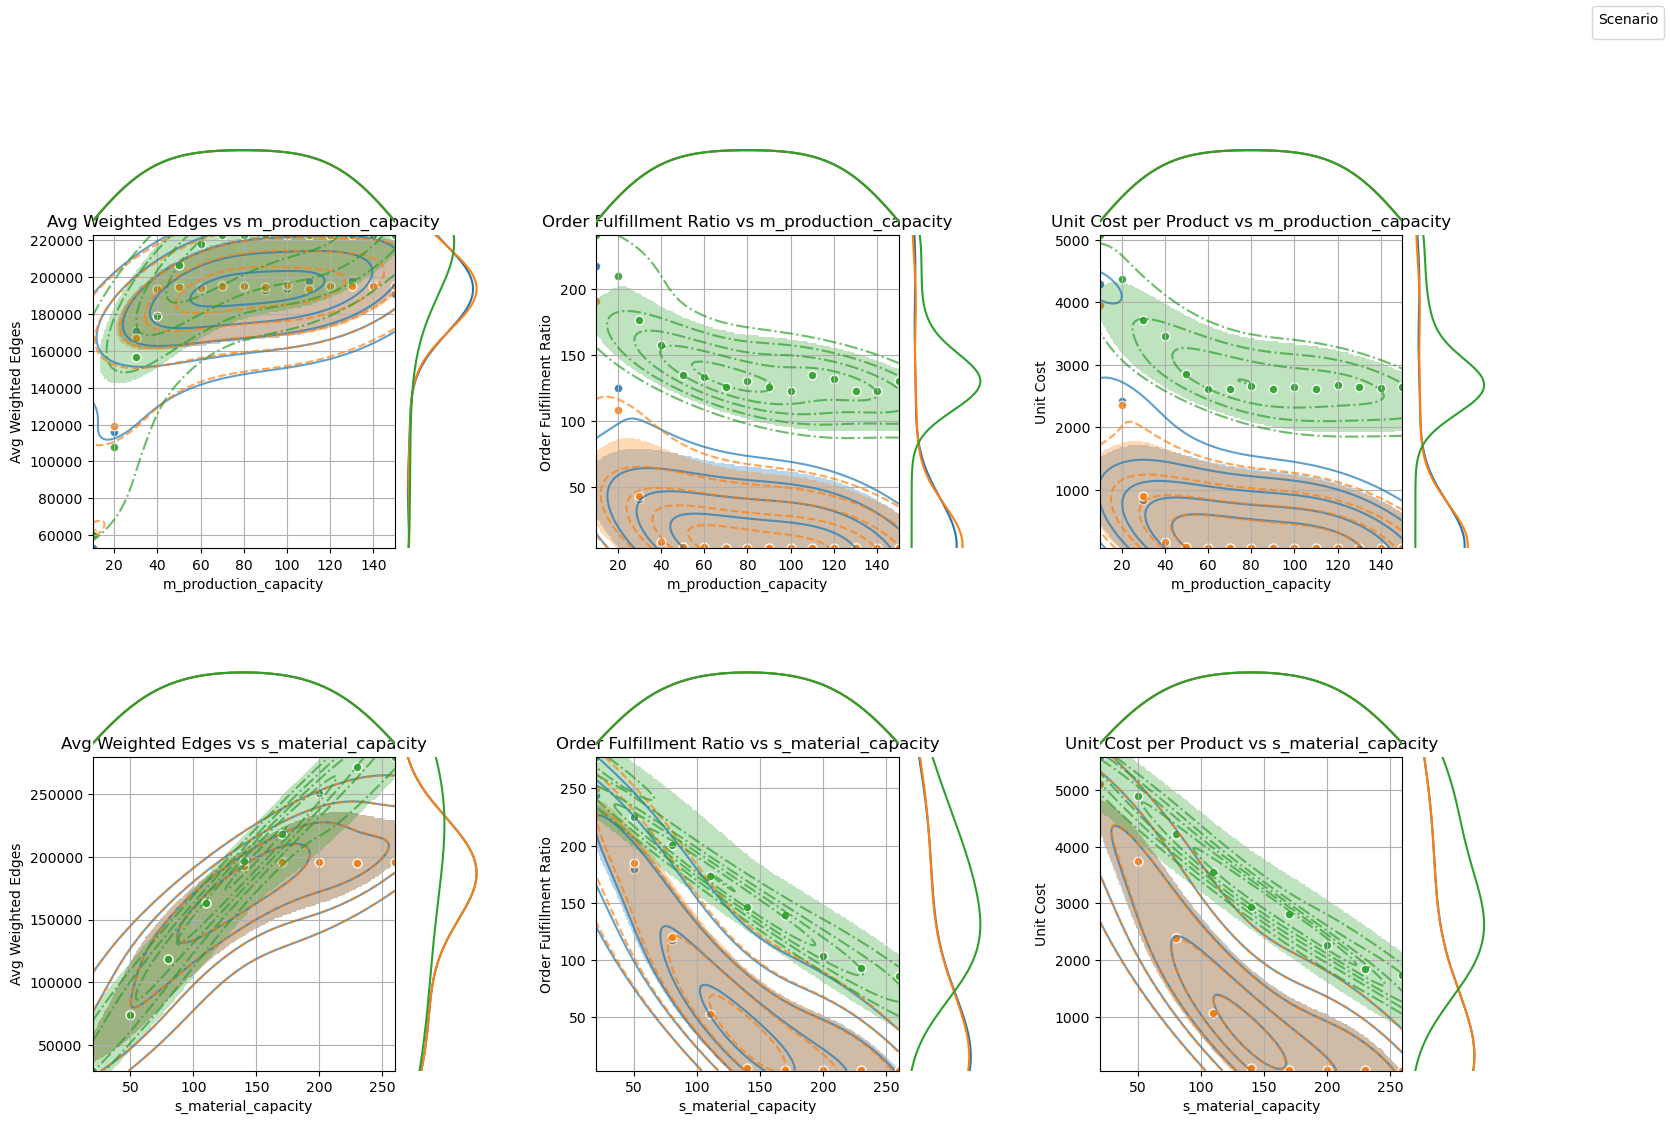

In [32]:
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde

# 场景及样式
scenarios  = ["Default", "Slow Logistics", "High Demand"]
colors     = ["C0", "C1", "C2"]
linestyles = ['-', '--', '-.']

# 指定六个子图： (metrics_dict, y_index, x_label, y_label, title)
combos = [
    (metrics_mprod, 1, 'm_production_capacity', 'Avg Weighted Edges',
     'Avg Weighted Edges vs m_production_capacity'),
    (metrics_mprod, 2, 'm_production_capacity', 'Order Fulfillment Ratio',
     'Order Fulfillment Ratio vs m_production_capacity'),
    (metrics_mprod, 3, 'm_production_capacity', 'Unit Cost',
     'Unit Cost per Product vs m_production_capacity'),
    (metrics_smat, 1, 's_material_capacity', 'Avg Weighted Edges',
     'Avg Weighted Edges vs s_material_capacity'),
    (metrics_smat, 2, 's_material_capacity', 'Order Fulfillment Ratio',
     'Order Fulfillment Ratio vs s_material_capacity'),
    (metrics_smat, 3, 's_material_capacity', 'Unit Cost',
     'Unit Cost per Product vs s_material_capacity'),
]

fig = plt.figure(figsize=(18, 12))
outer = GridSpec(2, 3, wspace=0.3, hspace=0.3)

for idx, (metrics_dict, yi, xlab, ylab, title) in enumerate(combos):
    row, col = divmod(idx, 3)
    inner = outer[row, col].subgridspec(
        2, 2,
        width_ratios=(4, 1),
        height_ratios=(1, 4),
        wspace=0.05, hspace=0.05
    )

    ax_main = fig.add_subplot(inner[1, 0])
    ax_x    = fig.add_subplot(inner[0, 0], sharex=ax_main)
    ax_y    = fig.add_subplot(inner[1, 1], sharey=ax_main)

    # 先拿到本图所有场景 x,y 的范围，做公共网格
    all_x = np.hstack([ [t[0] for t in metrics_dict[s]] for s in scenarios ])
    all_y = np.hstack([ [t[yi] for t in metrics_dict[s]] for s in scenarios ])
    xi, yi_grid = np.mgrid[
        all_x.min():all_x.max():200j,
        all_y.min():all_y.max():200j
    ]

    for scen, c, ls in zip(scenarios, colors, linestyles):
        arr = metrics_dict[scen]
        x   = np.array([t[0] for t in arr])
        y   = np.array([t[yi] for t in arr])

        # KDE & 密度矩阵
        kde = gaussian_kde(np.vstack([x, y]))
        zi  = kde(np.vstack([xi.ravel(), yi_grid.ravel()])).reshape(xi.shape)

        # 只填高于 75th 百分位的区域
        thresh  = np.percentile(zi, 75)
        zi_mask = np.ma.masked_less(zi, thresh)
        ax_main.contourf(
            xi, yi_grid, zi_mask,
            levels=[thresh, zi.max()],
            colors=[c],
            alpha=0.3,
            extend='neither'
        )
        # 叠加等高线
        ax_main.contour(
            xi, yi_grid, zi,
            levels=5,
            colors=[c],
            linestyles=ls,
            alpha=0.7
        )
        # 散点
        ax_main.scatter(
            x, y,
            c=c,
            edgecolor='white',
            s=40,
            label=scen if idx==0 else "",  # 只在第一个子图标一次
            alpha=0.9
        )
        # 上方边缘密度
        kde_x = gaussian_kde(x)
        xs    = np.linspace(all_x.min(), all_x.max(), 200)
        ax_x.plot(xs, kde_x(xs), color=c)
        # 右侧边缘密度
        kde_y = gaussian_kde(y)
        ys    = np.linspace(all_y.min(), all_y.max(), 200)
        ax_y.plot(kde_y(ys), ys, color=c)

    # 轴和标题
    ax_main.set_xlabel(xlab)
    ax_main.set_ylabel(ylab)
    ax_main.set_title(title)
    ax_main.grid(True)

    # 隐藏空轴刻度
    ax_x.axis('off')
    ax_y.axis('off')

# 总图例放在右上角
handles, labels = ax_main.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='Scenario')

plt.show()

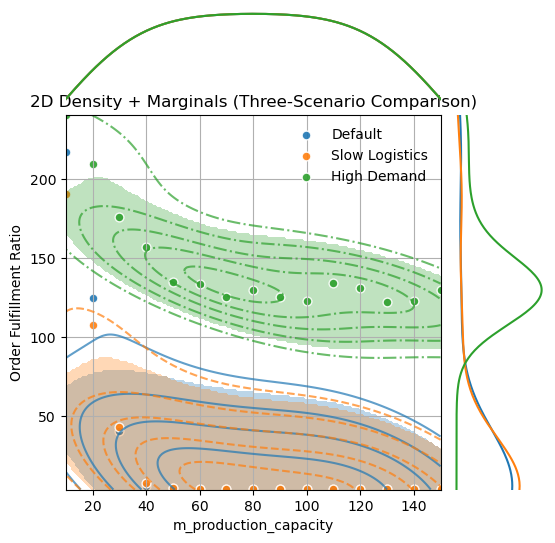

In [28]:
# scenarios and their plot styles
scenarios  = ["Default", "Slow Logistics", "High Demand"]
colors     = ["C0",        "C1",             "C2"]
linestyles = ['-',         '--',             '-.']

# --- Extract data from your metrics_mprod dict ---
# x = m_production_capacity
# y = Order Fulfillment Ratio (tuple index 2)
data = {}
for name in scenarios:
    arr = metrics_mprod[name]
    x = np.array([t[0] for t in arr])
    y = np.array([t[2] for t in arr])
    data[name] = {"x": x, "y": y}

# --- Build a common grid over all scenarios ---
all_x = np.hstack([d["x"] for d in data.values()])
all_y = np.hstack([d["y"] for d in data.values()])
xi, yi = np.mgrid[
    all_x.min():all_x.max():200j,
    all_y.min():all_y.max():200j
]

# --- Create figure with marginal axes ---
fig = plt.figure(figsize=(6, 6))
gs  = fig.add_gridspec(2, 2,
                       width_ratios=(4, 1),
                       height_ratios=(1, 4),
                       left=0.1, right=0.9,
                       bottom=0.1, top=0.9,
                       wspace=0.05, hspace=0.05)
ax_main = fig.add_subplot(gs[1, 0])
ax_x    = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_y    = fig.add_subplot(gs[1, 1], sharey=ax_main)

# --- Plot each scenario ---
for name, color, ls in zip(scenarios, colors, linestyles):
    x = data[name]["x"]
    y = data[name]["y"]
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    zi  = kde(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)

    # 1) Only fill regions above the 75th percentile density
    thresh   = np.percentile(zi, 75)
    zi_mask  = np.ma.masked_less(zi, thresh)
    ax_main.contourf(
        xi, yi, zi_mask,
        levels=[thresh, zi.max()],
        colors=[color],
        alpha=0.3,
        extend='neither'
    )

    # 2) Draw contour lines for all density levels
    ax_main.contour(
        xi, yi, zi,
        levels=5,
        colors=[color],
        linestyles=ls,
        alpha=0.7
    )

    # 3) Scatter the actual points
    ax_main.scatter(
        x, y,
        c=color,
        edgecolor='white',
        s=40,
        label=name,
        alpha=0.9
    )

    # 4) Marginal density on top (x-axis)
    kde_x = gaussian_kde(x)
    xs    = np.linspace(all_x.min(), all_x.max(), 200)
    ax_x.plot(xs, kde_x(xs), color=color)

    # 5) Marginal density on right (y-axis)
    kde_y = gaussian_kde(y)
    ys    = np.linspace(all_y.min(), all_y.max(), 200)
    ax_y.plot(kde_y(ys), ys, color=color)

# --- Final formatting ---
ax_main.set_xlabel("m_production_capacity")
ax_main.set_ylabel("Order Fulfillment Ratio")
ax_main.set_title("2D Density + Marginals (Three-Scenario Comparison)")
ax_main.grid(True)
ax_main.legend(frameon=False)

ax_x.axis('off')
ax_y.axis('off')

plt.show()

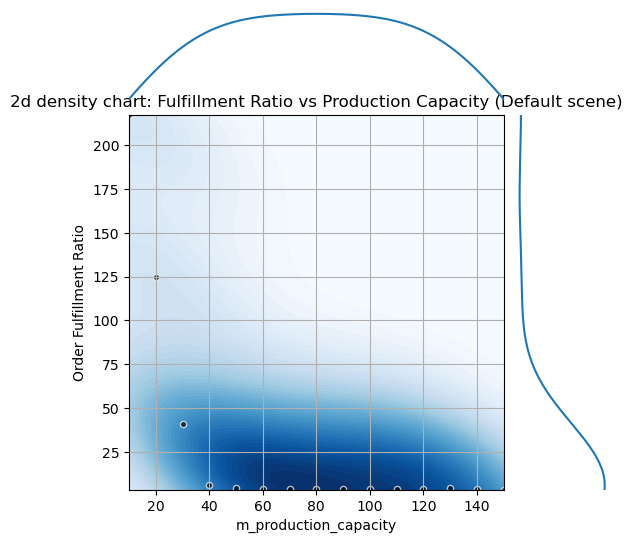

In [21]:
from scipy.stats import gaussian_kde

def plot_2d_density(x, y, xlabel, ylabel, title):
    """
    x, y         -- 一维 numpy 数组，表示要绘制的散点坐标
    xlabel, ylabel, title -- 图上对应的标签和标题
    """
    # 1) 计算点的联合密度
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)

    # 2) 在一个规则网格上评估密度
    xi, yi = np.mgrid[x.min():x.max():200j, y.min():y.max():200j]
    zi = kde(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)

    # 3) 构建带边缘坐标的小提琴图布局
    fig = plt.figure(figsize=(6, 6))
    gs = fig.add_gridspec(2, 2,
                          width_ratios=(4, 1),
                          height_ratios=(1, 4),
                          left=0.1, right=0.9,
                          bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)
    ax_main = fig.add_subplot(gs[1, 0])
    ax_xhist = fig.add_subplot(gs[0, 0], sharex=ax_main)
    ax_yhist = fig.add_subplot(gs[1, 1], sharey=ax_main)

    # 4) 主图：等高线密度 + 原始散点
    ax_main.contourf(xi, yi, zi, levels=50, cmap='Blues')
    ax_main.scatter(x, y, c='k', s=20, edgecolor='white', alpha=0.7)
    ax_main.set_xlabel(xlabel)
    ax_main.set_ylabel(ylabel)
    ax_main.set_title(title)
    ax_main.grid(True)

    # 5) 上侧边缘密度
    kde_x = gaussian_kde(x)
    x_vals = np.linspace(x.min(), x.max(), 200)
    ax_xhist.plot(x_vals, kde_x(x_vals))
    ax_xhist.axis('off')

    # 6) 右侧边缘密度
    kde_y = gaussian_kde(y)
    y_vals = np.linspace(y.min(), y.max(), 200)
    ax_yhist.plot(kde_y(y_vals), y_vals)
    ax_yhist.axis('off')

    plt.show()


# === 调用示例 ===
# 假设你已经得到了 metrics_mprod 字典
# x 方向用 m_production_capacity，y 方向用 Order Fulfillment Ratio
x = np.array([t[0] for t in metrics_mprod['Default']])
y = np.array([t[2] for t in metrics_mprod['Default']])

plot_2d_density(
    x, y,
    xlabel='m_production_capacity',
    ylabel='Order Fulfillment Ratio',
    title='2d density chart: Fulfillment Ratio vs Production Capacity (Default scene)'
)

In [22]:
# compare rm_procurement_mode(gap_based VS reorder_point in normal scenario)
# 公共参数
common_params = dict(
    heterogeneous=True,
    cust_demand_multiplier=1.0,
    m_production_capacity=50,
    m_inventory_capacity_product=300,
    m_inventory_capacity_material=600,
    s_material_capacity=150,
    m_cap_mode="heterogeneous",
    logistics_speed=2.0,
    # 这两个会在下面覆盖
    # rm_procurement_mode="gap_based",
    rm_reorder_point=100,
    rm_reorder_target=300,
    rm_purchase_multiplier=1.2,
    rm_produce_multiplier=1.1,
    product_order_mode="normal",
    material_order_mode="normal",
    total_steps=1000,
    num_reps=5,           # 建议多跑几次以估计 std
    change_schedule={},    # 本例无中途策略切换
    return_model=False
)

# 运行 gap_based
params_A = common_params.copy()
params_A["rm_procurement_mode"] = "gap_based"
print("=== Scenario: rm_procurement_mode = gap_based ===")
ratio_A, uc_A, mean_A, std_A, _ = run_simulation_with_param_changes(**params_A)
print(f"Overall production ratio: {ratio_A:.3f}")
print(f"Overall unit cost:       {uc_A:.3f}\n")

# 运行 reorder_point
params_B = common_params.copy()
params_B["rm_procurement_mode"] = "reorder_point"
print("=== Scenario: rm_procurement_mode = reorder_point ===")
ratio_B, uc_B, mean_B, std_B, _ = run_simulation_with_param_changes(**params_B)
print(f"Overall production ratio: {ratio_B:.3f}")
print(f"Overall unit cost:       {uc_B:.3f}\n")

# X 轴刻度
time_steps = np.arange(1, common_params["total_steps"] + 1)

# 画图：加权边数 Mean ± STD
plt.figure(figsize=(10,6))
plt.plot(time_steps, mean_A, label="gap_based", color="C0")
plt.fill_between(time_steps,
                 mean_A - std_A,
                 mean_A + std_A,
                 color="C0", alpha=0.2)
plt.plot(time_steps, mean_B, label="reorder_point", color="C1")
plt.fill_between(time_steps,
                 mean_B - std_B,
                 mean_B + std_B,
                 color="C1", alpha=0.2)
plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Comparison of rm_procurement_mode")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

=== Scenario: rm_procurement_mode = gap_based ===


ValueError: too many values to unpack (expected 5)

=== Scenario: rm_procurement_mode = gap_based ===
Overall production ratio: 55.006
Overall unit cost:       1146.922

=== Scenario: rm_procurement_mode = reorder_point ===
Overall production ratio: 52.345
Overall unit cost:       1103.926



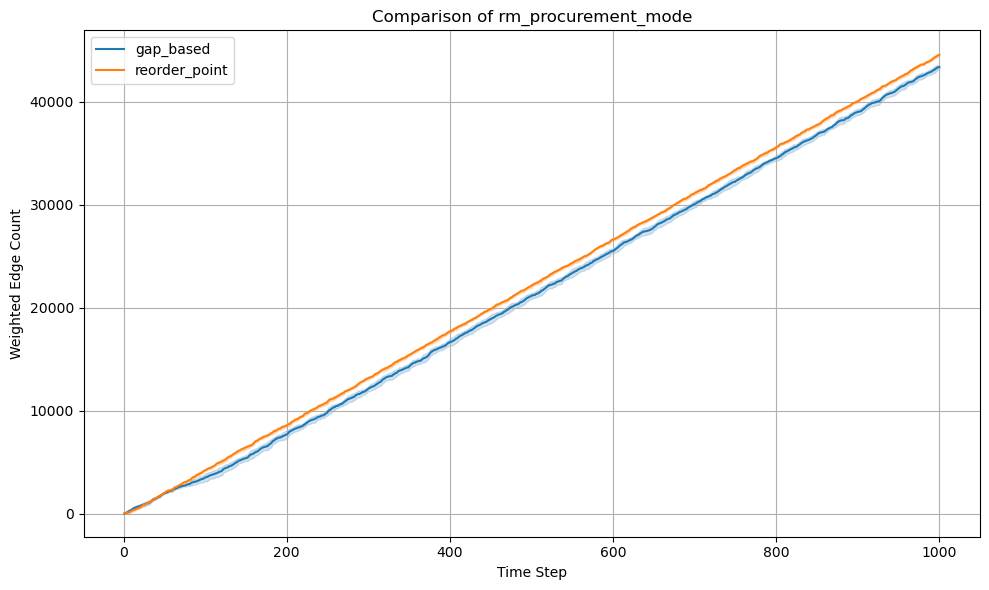

In [14]:
# compare rm_procurement_mode(gap_based VS reorder_point in material shortage disruption scenario)
# 公共参数
common_params = dict(
    heterogeneous=True,
    cust_demand_multiplier=1.0,
    m_production_capacity=50,
    m_inventory_capacity_product=300,
    m_inventory_capacity_material=600,
    s_material_capacity=30,
    m_cap_mode="heterogeneous",
    logistics_speed=2.0,
    # 这两个会在下面覆盖
    # rm_procurement_mode="gap_based",
    rm_reorder_point=100,
    rm_reorder_target=300,
    rm_purchase_multiplier=1.2,
    rm_produce_multiplier=1.1,
    product_order_mode="normal",
    material_order_mode="normal",
    total_steps=1000,
    num_reps=5,           # 建议多跑几次以估计 std
    change_schedule={},    # 本例无中途策略切换
    return_model=False
)

# 运行 gap_based
params_A = common_params.copy()
params_A["rm_procurement_mode"] = "gap_based"
print("=== Scenario: rm_procurement_mode = gap_based ===")
ratio_A, uc_A, mean_A, std_A, _ = run_simulation_with_param_changes(**params_A)
print(f"Overall production ratio: {ratio_A:.3f}")
print(f"Overall unit cost:       {uc_A:.3f}\n")

# 运行 reorder_point
params_B = common_params.copy()
params_B["rm_procurement_mode"] = "reorder_point"
print("=== Scenario: rm_procurement_mode = reorder_point ===")
ratio_B, uc_B, mean_B, std_B, _ = run_simulation_with_param_changes(**params_B)
print(f"Overall production ratio: {ratio_B:.3f}")
print(f"Overall unit cost:       {uc_B:.3f}\n")

# X 轴刻度
time_steps = np.arange(1, common_params["total_steps"] + 1)

# 画图：加权边数 Mean ± STD
plt.figure(figsize=(10,6))
plt.plot(time_steps, mean_A, label="gap_based", color="C0")
plt.fill_between(time_steps,
                 mean_A - std_A,
                 mean_A + std_A,
                 color="C0", alpha=0.2)
plt.plot(time_steps, mean_B, label="reorder_point", color="C1")
plt.fill_between(time_steps,
                 mean_B - std_B,
                 mean_B + std_B,
                 color="C1", alpha=0.2)
plt.xlabel("Time Step")
plt.ylabel("Weighted Edge Count")
plt.title("Comparison of rm_procurement_mode")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()